In [1]:
""" mostly plotting results for rocky planet evolution + topographies """
%matplotlib inline
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from collections.abc import Iterable
import collections
import six
from scipy import interpolate
import pandas as pd
from IPython.display import display, Math
import random as rand
import exotop.model_1D
from exotop.mpl_tools import colorize
import matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import rc

import pyshtools
import cartopy.crs as ccrs
# matplotlib.font_manager._rebuild()
rc('font',**{'family':'serif','serif':['CMU Serif Roman']}) # latex font for matplotlib
rc('text', usetex=True)
# np.seterr('raise')

# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop#
goodfig_path = 'latex/report-firstyr/figs/'

# plt.style.use('dark_background')

In [2]:
###### BUILD PLANETS IN BULK #####

def bulk_planets(N=1, name=None, mini=None, maxi=None, like=None, visc_type='Thi', t_eval=None, random=False,
                 T_m0=1750, T_c0=2250, D_l0=600e3, tf=4.5, 
                 update_kwargs=None, **kwargs): 
    """varying single parameter 'name' between mini and maxi, use default values otherwise."""
    
    if like is not None:
        pl_kwargs = eval('ins.'+like+'_in') 
        model_kwargs =  eval('ins.'+like+'_run')
    else:
        pl_kwargs = {}
        model_kwargs = dict(T_m0=T_m0, T_c0=T_c0, D_l0=D_l0, tf=tf, visc_type=visc_type) # model params
        
    if update_kwargs is not None:
        pl_kwargs.update(update_kwargs)
    
    planets = []
    ii=0
    arr = np.linspace(mini, maxi, num=N)
    while ii<N:
        if random:
            val = rand.uniform(mini, maxi)
        else:
            val = arr[ii]
        new_kwargs = pl_kwargs.copy()
        new_kwargs.update({name:val})
        pl = tp.TerrestrialPlanet(**new_kwargs)
        
        pl = therm.solve(pl, t_eval=t_eval, **model_kwargs) # T_m, T_c, D_l
        pl = top.topography(pl, C=1)
        planets.append(pl)
        ii+=1
    return planets

def build_planet(ident='Earthbaseline', run_args=None, update_args=None):
    planet_kwargs = eval('ins.'+ident+'_in') 
    model_kwargs = eval('ins.'+ident+'_run')
    if run_args is not None:
        model_kwargs.update(run_args)
    if update_args is not None:
        planet_kwargs.update(update_args)
    pl = tp.TerrestrialPlanet(**planet_kwargs)
    pl = therm.solve(pl, **model_kwargs) # T_m, T_c, D_l
    pl = top.topography(pl, C=2)
    return pl

def build_solarsystem(run_args=None, ident_list=['Moon1', 'Mercury1', 'Mars1', 'Venus', 'Earth'], dicts=False):
    planets = []
    for ii, ident in enumerate(ident_list):
        pl = build_planet(ident, run_args)
        planets.append(pl)
    if dicts:
        # Create a zip object from two lists
        z = zip(ident_list, planets)
        # Create a dictionary from zip object
        return dict(z)
    return planets

#planets = build_solarsystem()

In [3]:
###### PLOTTING ######

def plot_output(pl, names, ncols=6, tspan=None, title=None, plots_save=False, verbose=False,
                compare_dir=None, fig_path='figs/', labelpad=None,labelsize=15, legsize=10, fname=None,
                line_args=None, cmp_line_args=None, annotate_colour='xkcd:bright purple',
                print_tf=False, colorbar=False, legend=True, hidex=False, fformat='.pdf',
                ident=None, fig=None, axes=None, label=None, cmp_label=None,  ticksize=12,
                fontname=None, suptitlepad=1.04, legax=0, **kwargs):
     # names: y param
    if ident is None:
        ident = pl.ident
    if fname is None:
        fname = ident
    if line_args is None:
        line_args = {'lw':2, 'ls':'-', 'c':'k', 'marker':None, 'ms':5}
    if cmp_line_args is None:
        cmp_line_args = {'lw':1, 'ls':'-', 'c':'r', 'marker':None, 'ms':5}
    
    t = pl.t # time points of ode solutions in s
    
    nrows = int(np.ceil(len(names)/ncols))
    if (fig is None) and (axes is None):
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    if tspan is None:
        tspan = (0, t[-1]*1e-9/p.years2sec)
    out_vars = list(names.keys())
    ylabels = list(names.values()) # tuple (ylabel, yscale)
    if label is None:
        label = 'this work'
    for n, par in enumerate(out_vars):
        #loop across axes: each y axis variable
#         print('n', n, 'par', par)
        ax = axes.flatten()[n]
        y = eval('pl.'+par)
        if np.size(y)==1:
            y = [y]*len(t)
        try:
#             print('y', y)
            # if the name of the parameter you want to plot exists
            yl = str(ylabels[n][0])
            if par=='eta_m': # always log scale for viscosity
                y = np.log10(y)
            plot_one(ax, t*1e-9/p.years2sec, y*ylabels[n][1], xlabel='', ylabel=yl, ticksize=ticksize, labelpad=labelpad,
                     label=label, fontname=fontname, labelsize=labelsize, legsize=legsize, line_args=line_args)
            if compare_dir is not None: 
                # if data exists to benchmark this param
                try:
                    if (isinstance(compare_dir, collections.Iterable)) and (not isinstance(compare_dir, six.string_types)):
                        for cc, cdir in enumerate(compare_dir):
                            df = pd.read_csv(cdir+'/'+par+'.csv', header=None, names=['time', 'value'],
                                            index_col=False)
                            if cmp_label is None:
                                cmp_label=cdir
                            plot_one(ax, df['time'], df['value'], 
                                     '', yl, labelsize=labelsize, legsize=legsize,  ticksize=ticksize,
                                     label=cmp_label[cc], fontname=fontname, line_args=cmp_line_args[cc])
                    else:
                        # not iterable
                        df = pd.read_csv(compare_dir+'/'+par+'.csv', header=None, names=['time', 'value'],
                                            index_col=False)
                        if cmp_label is None:
                            cmp_label=compare_dir
                        plot_one(ax, df['time'], df['value'], 
                                 '', yl, labelsize=labelsize, legsize=legsize,  ticksize=ticksize,
                                 label=cmp_label, fontname=fontname, line_args=cmp_line_args)
                except IOError:
                    print('file', str(par+'.csv'), 'not found')
                    pass
            if par=='urey' and print_tf: # print final value of urey ratio
                ii = np.where(t*1e-9/p.years2sec<=tspan[-1])
                ax.annotate('%.2f'%(y[ii][-1]), xy=(tspan[-1], y[ii][-1]), fontsize=legsize, 
                            color=annotate_colour,
                            textcoords="axes fraction", xytext=(0.95, 0.2),
                            ha='right', va='bottom',
                            arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.1",
                                           ec=annotate_colour))
            ax.set_xlim(tspan)
            if legend and (n==legax):
                ax.legend(frameon=False, fontsize=legsize)
        except ValueError as e:
            print('could\'t plot', par)
            print(e)
    
    while n+1 < ncols*nrows :
        fig.delaxes(axes.flatten()[n+1])
        n += 1 # hide unused axes
    

    plot_setxlabel(axes, 'Age (Gyr)', 'bottom', fontname=fontname, labelpad=labelpad, labelsize=labelsize)
    if title is None:
        title = pl.ident
    fig.suptitle(title, fontsize=labelsize, y=suptitlepad, fontname=fontname)
    
    if colorbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(sc, cax=cbar_ax)
        sc.set_visible=False
    
    
    plt.tight_layout()
    if plots_save:
        plt.savefig(fig_path+fname+fformat, bbox_inches='tight') 
    if verbose:
        print('\n        n timesteps =', len(t))
        print('$t_f$ =', t[-1]*p.sec2Gyr, 'Gyr')
        print(r'$R_p$ =', '%.2f'%(pl.R_p/p.R_E), 'R_E =', '%.2f'%(pl.R_p*1e-3), 'km')
#         print(r'$R_c$ =', '%.2f'%(kwargs['CRF']*kwargs['R_p']*1e-3), 'km')
        print('M_c', '%.2e'%pl.M_c, 'kg')   
        print(r'$M_{m+lid}$ =', '%.2e'%(pl.M_m), 'kg')
        print(r'$g_{sfc}$ =', '%.2f'%pl.g_sfc, 'm s^-2')
        print(r'$g_{cmb}$ =', '%.2f'%pl.g_cmb, 'm s^-2')
        print(r'$\kappa_m$', '%.6f'%pl.kappa_m, 'm^2 s^-1')
        print(r'CRF =', '%.2f'%pl.CRF)
        print(r'$h_0$ =', '%.2f'%(pl.h_rad_m[0]*1e12), 'pW kg^-1')
        print(r'$h_{4.5}$ =', '%.2f'%(pl.h_rad_m[-1]*1e12), 'pW kg^-1')
#         print(r'$H_0$ =', '%.2f'%(H_rad_m[0] + H_rad_lid[0]), 'TW')
#         print(r'$H_{4.5}$ =', '%.2f'%(H_rad_m[-1] + H_rad_lid[-1]), 'TW')
        print(r'Urey ratio @ $t_f$ =', '%.2f'%pl.urey[-1])
        print('q_sfc(t=0)', '%.2f'%(pl.q_sfc[0]*1e3), 'mW m^-3')
    return fig, axes

def snaps(pl, plot_snapshots=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    try:
        n_col = len(plot_snapshots)
    except:
        n_col = 1
    fig2, axes2 = plt.subplots(1, n_col,figsize=(3*n_col,5))
    for iax, tx in enumerate(plot_snapshots): # tx is the time value u want nearest
        ii = min(enumerate(t), key=lambda x: abs(tx - x[1]*p.sec2Gyr))[0]
        plot_structure(ax=axes2[iax], t=t[ii], T_m=pl.T_m[ii], T_c=pl.T_c[ii], T_s=pl.T_s,
                       T_l=pl.T_l[ii], R_l=pl.R_l[ii], R_p=pl.R_p, R_c=pl.R_c, h_rad_m=pl.h_rad_m[ii],
                       d_lbl = pl.TBL_c[ii], d_ubl = pl.TBL_u[ii], q_ubl = pl.q_ubl[ii], a0=pl.a0[ii],
                       k_m=pl.k_m, legsize=10, **kwargs)
    plt.tight_layout()
    if plots_save:
        fig2.savefig(fig_path+pl.ident+'_profiles.pdf', bbox_inches='tight') 
    return fig2, axes2

def plot_structure(ax=None, t=None, T_m=None, T_c=None, R_p=None, R_l=None, R_c=None, T_l=None, 
                   T_s=None, h_rad_m=None, d_lbl=None, d_ubl=None, q_ubl=None, a0=None, k_m=None,
                   labelsize=16, legsize=14, Tlid_ini=None, **kwargs):
    """ plot temp structure (for a given time) """
    r_c = np.linspace(0, R_c*1e-3)
    r_lbl = np.linspace(R_c*1e-3, (R_c+d_lbl)*(1e-3))
    r_m = np.linspace((R_c+d_lbl)*1e-3, (R_l-d_ubl)*1e-3) # radius for mantle in km
    r_ubl = np.linspace((R_l-d_ubl)*1e-3, (R_l)*1e-3)
    r_l = np.linspace(R_l*1e-3, R_p*1e-3) # radius for lid
    T_cond = therm.sph_conduction(r_l*1e3, a0=a0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m, **kwargs)
    q = therm.sph_flux(r_l*1e3, a0=a0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m, **kwargs)
    if Tlid_ini=='linear':
        T_cond = therm.sph_conduction(r_l*1e3, a0=0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m,**kwargs)
        q = therm.sph_flux(r_l*1e3, a0=0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m,**kwargs)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
    ax.axhline(y=R_l*1e-3, ls='--', lw=1, c='xkcd:bluish purple')
    ax.axhline(y=R_c*1e-3, ls='--', lw=1, c='xkcd:clay')

    ax.plot(T_cond, r_l, c='xkcd:bluish purple')
    ax.plot(T_l + q_ubl/k_m*(R_l - r_ubl*1e3), r_ubl, c='xkcd:greenish')
    ax.plot([T_m]*len(r_m), r_m, c='xkcd:greenish')
    ax.plot([T_m, T_c], [(R_c+d_lbl)*1e-3, R_c*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_c]*len(r_c), r_c, c='xkcd:clay')
        
    ax.set_ylabel('Radius (km)', fontsize=labelsize)
    ax.set_xlabel('Temperature (K)', fontsize=labelsize)
    ax.set_ylim([0, R_p*1e-3])
#     #ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(T_cond[-1], 0, 'Core', ha='left', va='bottom', fontsize=legsize, c='xkcd:clay')
#     #ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(T_cond[-1], R_c*1e-3, 'Convecting region', ha='left', va='bottom', fontsize=legsize, c='xkcd:greenish')
    ax.text(T_cond[-1], R_l*1e-3, 'Lid', ha='left', va='bottom', fontsize=legsize, c='xkcd:bluish purple')
    
    ax2 = ax.twiny()
    ax2.set_xlabel('Flux, steady-state (mW m$^{-2}$)', color='xkcd:grey')  
    ax2.plot(q*1e3, r_l, color='xkcd:grey')
    ax2.plot(q_ubl*1e3, r_ubl[0], marker='o', color='xkcd:grey')
    ax2.annotate('$q_{ubl}$', (q_ubl*1e3, r_ubl[-1]), color='xkcd:grey', fontsize=12, ha="left", va="top")
    ax2.tick_params(axis='x', labelcolor='xkcd:grey')
    
    ax.set_title(('%.1f'%(t*1e-9/p.years2sec))+' Gyr', fontsize=labelsize)

    return ax

def interp_benchmark(path, yscale=1):
    df = pd.read_csv(path, header=None, names=['time', 'value'], index_col=False) 
    f = interpolate.interp1d(np.array(df['time']), np.array(df['value'])*yscale, kind='linear')
    times = df['time'] # in Gyr 
    return np.array(times), f

def plot_qsfc_error(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on q_sfc """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    temp = t*1e-9/p.years2sec # in Gyr
    
    try:
        t_T_l, f_T_l_interp = interp_benchmark(path=compare_dir+'/T_l.csv')# in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_l_interp = f_T_l_interp(times0) # published plot interpolated to model times, in K
    except FileNotFoundError as e:
        t_T_l, f_T_avg_interp = interp_benchmark(path=compare_dir+'/T_avg.csv') # in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_avg_interp = f_T_avg_interp(times0) # published plot interpolated to model times, in K
        T_l_interp = Tl_from_Tmean(R_l=pl.R_l[iii], T_avg=T_avg_interp, a0=pl.a0[iii], **kwargs)
    

    D_l_interp = f_D_l_interp(times0) # published plot interpolated to model times, in m
    R_l_interp = pl.R_p - D_l_interp
    q_sfc_interp = therm.sph_flux(pl.R_p, a0=pl.a0[iii], T_l=T_l_interp, T_s=pl.T_s, R_l=R_l_interp, 
                                  R_p=pl.R_p, k_m=pl.k_m, **kwargs) # sfc flux in W m^-2

    ax3.plot(times0, pl.q_sfc[iii]*1e3, c='xkcd:black', label='this work')
    ax3.plot(times0, q_sfc_interp*1e3, c='xkcd:blue', label='Thiriet interp')
    df = pd.read_csv(compare_dir+'/q_sfc.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$q_{sfc}$ (mW m$^{-2}$)', fontsize=16)

#     plt.tight_layout()

    fig0, ax0 = plt.subplots(1,1,  figsize=(4,4))
    ax0.plot(times0, pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3, c='xkcd:grey')
    ax0.set_xlabel('Time (Gyr)', fontsize=14)
    ax0.set_ylabel('$\Delta q_{sfc}$ (mW m$^{-2}$)', fontsize=14)
    ax0.set_title('Mean error: $\pm$'+'%.2f'%np.mean(np.absolute(pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3))+' mW m$^{-2}$', 
                  fontsize=14)
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_qsfc.pdf')
        fig0.savefig(fig_path+pl.ident+'_q_error.pdf')

def plot_Tavg(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on T_avg """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s

    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    # plot your T_avg calculation but using interpolated published D_l    
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    
    # select model time points in interpolation range
    temp = t*1e-9/p.years2sec # in Gyr
    iii = np.where((temp>=t_D_l.min()) & (temp<=t_D_l.max()))
    times0 = temp[iii] # time points of ODE solver subset to interpolation range
    D_l_interp = f_D_l_interp(times0) # published D_l at model time points in m
    R_l_interp = pl.R_p - D_l_interp # m
    
    T_avg_interp = therm.T_mean(T_m=pl.T_m[iii], T_l=pl.T_l[iii], R_p=pl.R_p, R_l=R_l_interp, 
                                R_c=pl.R_c, a0=pl.a0[iii], T_s=pl.T_s, k_m=pl.k_m, **kwargs)
    ax3.plot(times0, pl.T_avg[iii], c='xkcd:black', label='this work')
    ax3.plot(times0, T_avg_interp, c='xkcd:blue', label='this work with Thiriet D_l')
    df = pd.read_csv(compare_dir+'/T_avg.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$T_{avg}$ (K)', fontsize=16)  
    ax3.set_title('blue should match red')
    
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_Tavg.pdf')
        
def plot_one(ax, x, y, xlabel, ylabel, labelsize=15, legsize=16, ticksize=12, line_args=None,
             text=None, xticks=True, ylim=None, label=None,labelpad=None, fontname=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize, fontname=fontname, labelpad=labelpad)
    ax.set_ylabel(ylabel, fontsize=labelsize, fontname=fontname, labelpad=labelpad)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, label=label, **line_args)
    ax.set_xlim(x.min(), x.max())
    ax.tick_params(axis='x', labelsize=ticksize) 
    ax.tick_params(axis='y', labelsize=ticksize) 
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=15, fontname=None, labelpad=None, **kwargs):
    try:
        ny, nx = np.shape(axes) # assume 2D
        for ii, ax in enumerate(axes):
            for jj, a in enumerate(ax):
                if (style=='all') or ((style=='bottom') and (ii==ny-1)):
                    a.set_xlabel(label, fontsize=labelsize, fontname=fontname)
                if (style=='bottom') and (ii<ny-1):
                    a.set_xticks([])
    except ValueError: # 1D
        ny = 1
        try:
            for jj, a in enumerate(axes):
                a.set_xlabel(label, fontsize=labelsize, fontname=fontname, labelpad=labelpad)
        except TypeError: # single
            axes.set_xlabel(label, fontsize=labelsize, fontname=fontname, labelpad=labelpad)
                
def Tl_from_Tmean(R_c=None, R_l=None, R_p=None, T_avg=None, T_s=None, a0=None, k_m=None, **kwargs):
    """solved for T_l using sympy"""
    return (k_m*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4)*(-60*Ea*R_c**6*k_m + 60*Ea*R_c**3*R_l**3*k_m + 30*Ea*R_c**3*R_l**2*R_p*k_m + 30*Ea*R_c**3*R_l*R_p**2*k_m - 30*Ea*R_l**5*R_p*k_m - 30*Ea*R_l**4*R_p**2*k_m + 120*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m - 8*R_b*R_l**8*a0*a_rh + 14*R_b*R_l**7*R_p*a0*a_rh + 9*R_b*R_l**6*R_p**2*a0*a_rh - 20*R_b*R_l**5*R_p**3*a0*a_rh - 60*R_b*R_l**5*R_p*T_s*a_rh*k_m - 10*R_b*R_l**4*R_p**4*a0*a_rh - 30*R_b*R_l**4*R_p**2*T_s*a_rh*k_m + 18*R_b*R_l**3*R_p**5*a0*a_rh - 120*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m + 180*R_b*R_l**3*R_p**3*T_s*a_rh*k_m + R_b*R_l**2*R_p**6*a0*a_rh + 60*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m - 30*R_b*R_l**2*R_p**4*T_s*a_rh*k_m - 4*R_b*R_l*R_p**7*a0*a_rh + 60*R_b*R_l*R_p**5*T_avg*a_rh*k_m - 60*R_b*R_l*R_p**5*T_s*a_rh*k_m) - 2*sqrt(15)*sqrt(Ea*k_m**3*(60*Ea*R_c**6*k_m - 60*Ea*R_c**3*R_l**2*R_p*k_m - 60*Ea*R_c**3*R_l*R_p**2*k_m + 15*Ea*R_l**4*R_p**2*k_m + 30*Ea*R_l**3*R_p**3*k_m + 15*Ea*R_l**2*R_p**4*k_m - 240*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m + 16*R_b*R_l**8*a0*a_rh - 28*R_b*R_l**7*R_p*a0*a_rh - 18*R_b*R_l**6*R_p**2*a0*a_rh + 40*R_b*R_l**5*R_p**3*a0*a_rh + 120*R_b*R_l**5*R_p*T_s*a_rh*k_m + 20*R_b*R_l**4*R_p**4*a0*a_rh + 60*R_b*R_l**4*R_p**2*T_s*a_rh*k_m - 36*R_b*R_l**3*R_p**5*a0*a_rh + 240*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m - 360*R_b*R_l**3*R_p**3*T_s*a_rh*k_m - 2*R_b*R_l**2*R_p**6*a0*a_rh - 120*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m + 60*R_b*R_l**2*R_p**4*T_s*a_rh*k_m + 8*R_b*R_l*R_p**7*a0*a_rh - 120*R_b*R_l*R_p**5*T_avg*a_rh*k_m + 120*R_b*R_l*R_p**5*T_s*a_rh*k_m))*(R_c - R_l)*(R_l - R_p)**2*(2*R_l + R_p)**2*(R_c**2 + R_c*R_l + R_l**2))/(30*R_b*R_l**2*a_rh*k_m**2*(R_l - R_p)**2*(2*R_l + R_p)**2*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4))

def powerspectrum_RMS(path, amplitude=False): # try to calcuate RMS from digitized power spectrum
    df = pd.read_csv(path, header=None, names=['degree', 'value'], index_col=False) 
    ls = np.array(df['degree'])
    S = np.array(df['value'])
    RMS_l = []
    for ii, l in enumerate(ls):
        val = np.sqrt(S[ii]/(2*l + 1))
        if amplitude:
            val = val**2
        RMS_l.append(val)
    return sum(RMS_l)

def eta_from_Ra(rho=None, g=None, alpha=None, dT=None, d=None, kappa=None, Ra=None):
    return rho*g*alpha*dT*d**3/(kappa*Ra)

def Ra_from_RaB(F=None, dT=1000, l=None, k=None, Ra_B=None):
    # convert between basal heating Ra and internal Ra, given F flux into base
    return Ra_B * k*dT/(F*l) # basal heating Ra_B

def Ra_from_RaF_2(F=74e-3, dT=1000, l=750e3, kappa=8e-7, rho=3300, c_p=1200, Ra_F=2.4e6): # moresi and parsons
    return Ra_F*(rho*c_p*kappa*dT)/(l*F)

def Ra_from_RaF(F=None, dT_m=None, k=None, l=None, Ra_F=None, **kwargs): # F is surface flux
    return Ra_F/(l*F/(k*dT_m))

def benchmark_thermal_plots(ident, show_qsfc_error=False, show_Tavg=False, names=None, pl_update_args=None,
                            model_update_args=None, **kwargs):
    if names is None:
            names = {'T_avg':('$T_{avg}$ (K)',1), 
                     'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
                     'D_l':('$D_l$ (km)',1e-3),
                     'q_core':('$q_{B}$ (mW m$^{-2}$)', 1e3), 
                     'urey':('Ur',1),
                     'T_l':('$T_l$ (K)',1), 
                    }
    planet_kwargs = eval('ins.'+ident+'_in') 
    model_kwargs = eval('ins.'+ident+'_run')
    if pl_update_args is not None:
        planet_kwargs.update(pl_update_args)
    if model_update_args is not None:
        model_kwargs.update(model_update_args)
    pl = tp.TerrestrialPlanet(**planet_kwargs)
    pl = therm.solve(pl, **model_kwargs) # T_m, T_c, D_l

    print('T_mf', pl.T_m[-1])

    fig, axes = plot_output(pl, names, verbose=False, **kwargs)
    if show_qsfc_error:
        plot_qsfc_error(pl, ident=ident, **kwargs)
    if show_Tavg:
        plot_Tavg(pl, **kwargs)
    return fig, axes

def plot_vs_x(scplanets=None, lplanets=None, xname=None, ynames=None, planets2=None, fig=None, axes=None,
              labels=False, labelsize=15, legsize=12, alpha=1, legend=False, snap=4.5,labelpad=None,
              plots_save=False, s=30, ls='-', lw=1, cmap='rainbow', marker='o', legtitle=None, legendtop=False,
              colorbar=False, c='k', ylabel=True, ymin=None, ymax=None, set_ylim=True, set_xlim=False,
              zorder_l=None, zorder_sc=None, label_l=None, fname=None, ticksize=12, xmin=None, xmax=None, **kwargs):
        # for a list of planets, plot some parameter on the y axis vs. parameter x
    if (c is None) and (scplanets is not None):
        c = np.arange(len(scplanets))
#         colour = cm.get_cmap(cmap)
#         norm = colors.Normalize(vmin=0, vmax=len(planets))
    nax = len(ynames)
    if xmin is not None:
        set_xlim=True
    if axes is None:
        fig, axes = plt.subplots(1, nax, figsize=(5*nax, 4))
    
    xparam = list(xname.keys())[0]
    xlabels = list(xname.values())[0]
    yparam = list(ynames.keys())
    ylabels = list(ynames.values()) # tuple (ylabel, yscale)
    
    
    ii=0
    while ii < nax:
        try:
            ax = axes[ii]
        except TypeError: # single ax
            ax = axes
        if scplanets is not None:
            x = []
            y = []
            for ip, pl in enumerate(scplanets): # planets to plot as scatter
                data_x = eval('pl.'+xparam)*xlabels[1]
                if isinstance(data_x, Iterable):
                    data_x = data_x[-1] # get final value
                x.append(data_x)
                data_y = eval('pl.'+yparam[ii])*ylabels[ii][1]
                if isinstance(data_y, Iterable):
                    data_y = data_y[-1] # get final value
                y.append(data_y) 
                if labels:
                    ax.annotate(xy=(data_x,data_y), s=pl.ident[0:2], fontsize=legsize)
            sc = ax.scatter(x, y, c=c, s=s, marker=marker, cmap=cmap, zorder=zorder_sc)
            if colorbar and (ii==0):
                plt.colorbar(sc)
        if lplanets is not None:
            x = []
            y = []
            try:
                for ip, pl in enumerate(lplanets): # planets to plot as line
                    t = pl.t
                    it = min(enumerate(t), key=lambda x: abs(snap - x[1]*p.sec2Gyr))[0] # get time index nearest to desired snap given in Gyr
                    data_x = eval('pl.'+xparam)*xlabels[1]
                    if isinstance(data_x, Iterable):
                        data_x = data_x[it] # if an evolution model then take certain snap
                    x.append(data_x)
                    data_y = eval('pl.'+yparam[ii])*ylabels[ii][1]
                    if isinstance(data_y, Iterable):
                        data_y = data_y[it] # if an evolution model then take certain snap
                    y.append(data_y) 
            except TypeError: # if given a single planet (not iterable) - get values across evol
                x = eval('lplanets.'+xparam)*xlabels[1]
                y = eval('lplanets.'+yparam[ii])*ylabels[ii][1]
            # sort
            if isinstance(y, Iterable) and isinstance(x, Iterable):
                x, y = zip(*sorted(zip(x, y)))
            elif isinstance(y, Iterable) and (not isinstance(x, Iterable)):
                x, y = zip(*sorted(zip([x]*np.ones_like(y), y)))
            elif (not isinstance(y, Iterable)) and isinstance(x, Iterable):
                x, y = zip(*sorted(zip(x, [y]*np.ones_like(x))))    

            ax.plot(x, y, ls=ls, c=c, lw=lw, alpha=alpha, zorder=zorder_l, label=label_l)
        if ylabel:
            ax.set_ylabel(ylabels[ii][0], fontsize=labelsize, labelpad=labelpad)
            ax.tick_params(axis='y', labelsize=ticksize) 
        else:
            ax.yaxis.set_ticklabels([])
        ax.tick_params(axis='x', labelsize=ticksize) 
        
        # log scale for viscosity
        if (yparam[ii] is 'eta_m') or (yparam[ii] is 'nu_m') or (yparam is 'Ra_i'):
            ax.set_yscale('log')
        if (xparam is 'eta_m') or (xparam is 'nu_m') or (xparam is 'eta_0') or (xparam is 'Ra_i'):
            ax.set_xscale('log')
        
        if set_ylim:
            ax.set_ylim(ymin, ymax)
        if set_xlim:
            ax.set_xlim(xmin, xmax)

        if legend:

            if legendtop:
                legend=ax.legend(frameon=False, fontsize=legsize,  
                                 borderaxespad=0, title=legtitle,  #mode="expand", 
                                 loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2,)
           
            else:
                legend=ax.legend(frameon=False, fontsize=legsize, loc='upper left', 
                             bbox_to_anchor= (1.05, 0.9),
                             borderaxespad=0, ncol=1, title=legtitle)
            if legtitle is not None:
                    plt.setp(legend.get_title(),fontsize=legsize)
                    legend._legend_box.align = "left"
        ii+=1
    plot_setxlabel(axes, xlabels[0], 'all', labelsize=labelsize, labelpad=labelpad, **kwargs)
    
    plt.tight_layout()
    if plots_save:
        if fname is None:
            fname = 'scatter_'+xparam
        plt.savefig(fig_path+fname+'.pdf', bbox_inches='tight') 
    return fig, axes

In [4]:
# make a plot of h vs. Ra - single planet evolution
# add literature model data to plot

def hprime_MP(h=None, alpha=None, d=None, F=None, C_p=None, kappa=None, Ra_b=None, eta_0=None, 
              rho=None, g=None, k=None, dT=None):
    
    if eta_0 is None:
        if dT is None:
            eta_0 = rho*g*alpha*d**4*F/(k*kappa*Ra_b)
        elif F is None:
            eta_0 = rho*g*alpha*d**3*dT/(kappa*Ra_b)
    return h/(eta_0*kappa/(d**2*rho*g))


def hprime_v_Ra(plots_save=False, figpath='', fname='fig', legsize=14, leg_ncol=1, legtitle=r'\textbf{\textit{Model}}', **kwargs):
    pl_list = build_solarsystem(dicts=True, run_args={'D_l0':10e3, 'T_m0':1700},
                                ident_list=['Venusbaseline'])

    # TODO: colour code by viscosity or geometry


    pl = pl_list['Venusbaseline'] # planets
    a_rh = pl.a_rh
    alpha = pl.alpha_m
    T_m = pl.T_m[-1]
    Ea = pl.Ea
    dT_rh = p.R_b*T_m**2/Ea
    dT_m =  pl.deltaT_m
    
    eta_m = pl.eta_m[-1]
    kappa_m = pl.kappa_m
    d_m = pl.d_m
    Ra_crit = pl.Ra_crit_u
    Ra = np.logspace(4, np.log10(np.max(pl.Ra_i)))

    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5,7))
    
    ax0.set_yscale('log')
    ax1.set_yscale('log')
    
    # plot Ra scaling across the board from PD and stress , i guess fixing some parameters
    
    h_PD83_Ra = 5.4*alpha*d_m[-1]*(a_rh*dT_rh*dT_m[-1]/Ra_crit**(1/3))**0.5 * Ra**(-1/3)
    hprime_PD83_Ra = h_PD83_Ra / (pl.eta_m[-1]*kappa_m/(d_m[-1]**2*pl.rho_m*pl.g_sfc))
    print('model scaling, $h_{km}$ = $h\prime x', 1e-3*pl.eta_m[-1]*kappa_m/(d_m[-1]**2*pl.rho_m*pl.g_sfc))

    ax0.plot(Ra, hprime_PD83_Ra, lw=1, ls='--', c='k', 
            label=r'Parsons \& Daly (1983) RMS scaling') 
    
#     ax0.plot(Ra, h_PD83_Ra/(alpha*dT_m[-1]*d_m[-1]), lw=1, ls='--', c='k', 
            #label=r'Parsons \& Daly (1983) scaling') 
    ax1.plot(Ra, h_PD83_Ra/(alpha*dT_m[-1]*d_m[-1]), lw=1, ls='--', c='k') 
    

    fig, ax1 = plot_vs_x(lplanets=pl, xname = {'Ra_i':('Ra', 1)}, 
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{RMS}$', eval('(pl.alpha_m*pl.deltaT_m*pl.d_m)**-1'))},
                         set_ylim=False,
                        c='k', ls='-', lw=3, 
                        label_l=r'Parsons \& Daly (1983) with thermal history',
                        fig=fig, axes=ax1, **kwargs)
    
    pl_h_scale = hprime_MP(h=1, alpha=pl.alpha_m, d=pl.d_m[-1], dT=pl.deltaT_m[-1], kappa=pl.kappa_m, 
                           eta_0=pl.eta_m[-1], rho=pl.rho_m, g=pl.g_sfc, k=pl.k_m)
    print('pl_h_scale', pl_h_scale, 'hprime = scale times h')
    
    # dummy
    fig, ax0 = plot_vs_x(lplanets=pl,     xname = {'Ra_i':('Ra$_B$', 1)},
                         ynames={'dyn_top_rms':('$\Delta h^\prime_{peak}$', 
                                               pl_h_scale)}, 
                         set_ylim=False,c='w',fig=fig, axes=ax0, **kwargs)
    



    
    # plot Lees fit free-slip (free-free) - our PD is scaled to match their RMS, exponent lower than -1/3 because dT is outside scaling
    #h_rms_prime_Lees = 1.191*Ra**-0.289
    Ra_l = [1e6, 3e5, 1e5]
    h_rms_prime_Lees = np.array([235/442, 476/651, 943/912])/(4e-5*600e3)
    ax1.scatter(Ra_l, h_rms_prime_Lees, marker='*', c='b', s=70,
                label=r'Lees+ (2020)') 

 
#     # load data points from model run
#     df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
#     h_peak_JFR = np.array(df.peak_topo)
#     h_rms_JFR = np.array(df.RMS_topo)
#     ax0.scatter(np.array(df.Ra), h_peak_JFR, marker='x', c='xkcd:blurple', 
#                label='cylindrical peak')
#     ax1.scatter(np.array(df.Ra), h_rms_JFR, marker='x', c='xkcd:lavender', 
#                label='cylindrical RMS')
#     print('h_RMS/h_peak, cylindrical = ',h_rms_JFR/ h_peak_JFR)
    
    
    # KH92 for Ra 10^4-10^5 constant eta
    Ra = np.logspace(4, 5)
    h_KH92 = (66*Ra**-0.121)*0.7e3 
    hprime_KH92 = hprime_MP(h=h_KH92, alpha=3e-5, d=2800e3, dT=1000, kappa=1e-6, Ra_b=2.4e6, rho=3300, g=8.87, k=3)
    Nu = 0.27*Ra**0.319
    Ra_B = Ra*Nu
    ax0.plot(Ra*Nu, hprime_KH92, lw=2, ls='--', c='xkcd:raspberry', 
            label=r'Kiefer \& Hager (1992) peak scaling') # scaled from dimensional
    
    Ra2 = np.logspace(5, 6)
    Nu2 = 0.27*Ra2**0.319
    h_KH92 = (66*Ra2**-0.121)*0.7e3
    #hprime_KH92 = h_KH92/(3e-5*1000*2800e3)
    hprime_KH92 = hprime_MP(h=h_KH92, alpha=3e-5, d=2800e3, dT=1000, kappa=1e-6, Ra_b=2.4e6, rho=3300, g=8.87, k=3)
    
    ax0.plot(Ra2*Nu2,  hprime_KH92,
             lw=1, ls='--', c='xkcd:raspberry', alpha=0.3,
            ) 
    
    # RMS scatter for Moresi & Parsons  
#     data_Moresi_h = np.array([5.8e3/(3.28e-5*1100*750e3), 
#                               3.8e3/(3.28e-5*1100*750e3), 
#                               5.1e3/(3.28e-5*1100*750e3)])
    data_Moresi_hprime = [hprime_MP(h=5.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168),
                     hprime_MP(h=3.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168),
                     hprime_MP(h=5.1e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168)]
      
    print('MP: $h{_km}$ = $h\prime$ x ', 5.8/hprime_MP(h=5.8e3, alpha=3.28e-5, d=750e3, F=75e-3, kappa=8e-7, Ra_b=2.4e6, rho=3300, g=8.87, k=3.168))    
    data_Moresi_Ra = [2.4e6,
                     1.3e6,
                     1e6]
    ax0.scatter(data_Moresi_Ra, data_Moresi_hprime, marker='v', s=70, alpha=0.9,
               c='xkcd:carnation', 
               label=r'Moresi \& Parsons (1995)$^\dagger$')
    
    # plot scatter points from Nimmo
    data_Nimmo_h = [2.847/(3.28e-5*1000*840e3), 
                    1.914/(3.28e-5*1000*760e3), 
                    1.729/(3.28e-5*1000*695e3), 
                    
                    2.585/(3.28e-5*1000*910e3), 
                    2.416/(3.28e-5*1000*860e3), 
                    1.629/(3.28e-5*1000*775e3), 
                    1.955/(3.28e-5*1000*775e3), 
                    2.604/(3.28e-5*1000*775e3), 
                    2.173/(3.28e-5*1000*775e3), 
                    1.467/(3.28e-5*1000*705e3), 
                    
                    2.217/(3.28e-5*1000*950e3), 
                    2.328/(3.28e-5*1000*950e3), 
                    2.772/(3.28e-5*1000*950e3), 
                    2.023/(3.28e-5*1000*890e3), 
                    2.225/(3.28e-5*1000*890e3), 
                    2.529/(3.28e-5*1000*890e3), 
                    1.278/(3.28e-5*1000*775e3), 
                    1.703/(3.28e-5*1000*775e3), 
                    1.789/(3.28e-5*1000*775e3), 
                    1.157/(3.28e-5*1000*705e3)] 
    
    data_Nimmo_hprime = [
        hprime_MP(h=2.847e3, alpha=3.28e-5, d=840e3, F=20e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.914e3, alpha=3.28e-5, d=760e3, F=15e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.729e3, alpha=3.28e-5, d=695e3, F=15e-3, kappa=8e-7, Ra_b=3.95e6, rho=3300, g=8.87, k=3.17),
        
        hprime_MP(h=2.585e3, alpha=3.28e-5, d=910e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.416e3, alpha=3.28e-5, d=860e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.629e3, alpha=3.28e-5, d=775e3, F=15e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.955e3, alpha=3.28e-5, d=775e3, F=18e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.604e3, alpha=3.28e-5, d=775e3, F=19e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.173e3, alpha=3.28e-5, d=775e3, F=20e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.467e3, alpha=3.28e-5, d=705e3, F=15e-3, kappa=8e-7, Ra_b=7.86e6, rho=3300, g=8.87, k=3.17),
        
        hprime_MP(h=2.217e3, alpha=3.28e-5, d=950e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.328e3, alpha=3.28e-5, d=950e3, F=21e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.772e3, alpha=3.28e-5, d=950e3, F=25e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.023e3, alpha=3.28e-5, d=890e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.225e3, alpha=3.28e-5, d=890e3, F=22e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=2.529e3, alpha=3.28e-5, d=890e3, F=25e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.278e3, alpha=3.28e-5, d=775e3, F=15e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.703e3, alpha=3.28e-5, d=775e3, F=20e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.789e3, alpha=3.28e-5, d=775e3, F=21e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
        hprime_MP(h=1.157e3, alpha=3.28e-5, d=705e3, F=15e-3, kappa=8e-7, Ra_b=1.58e7, rho=3300, g=8.87, k=3.17),
    ]
    
    data_Nimmo_Ra = [3.95e6, 3.95e6,3.95e6,
                     7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,7.89e6,
                     1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,1.58e7,]
    
    
    ax0.scatter(data_Nimmo_Ra, data_Nimmo_hprime, marker='d', s=70, alpha=0.7,
               c='xkcd:pale orange', 
               label=r'Nimmo \& McKenzie (1996)$^\dagger$')
    
    # plot scatter points from KK98 model1
    data_KK98_h = np.array([0.006, 0.01])*pl.R_p/2800e3 # convert from their nondimensionalization to match KH
    data_KK98_Ra = [1e6, 1e6]
    ax1.plot(data_KK98_Ra, data_KK98_h, marker='.', ls='-', lw=1, alpha=0.9,
               c='xkcd:carnation', ms=10,
               label=r'Kiefer \& Kellogg (1998)')

    
#     # RMS scatter for Wei+ 2014    
#     data_Wei_Ra = 1.8e7
#     data_Wei_h = powerspectrum_RMS('benchmarks/wei_Venus/model_power_m2_b.csv')*1e-3
#     ax.scatter(data_Wei_Ra, data_Wei_h, marker='s', s=70, alpha=0.9,
#            c='xkcd:orchid', 
#            label=r'Huang+ (2013)$^\ddagger$')

    
#     # RMS scatter for Yang2016  
#     data_Yang_h = powerspectrum_RMS('benchmarks/yang_Venus/h_amplitude_m.csv', amplitude=True)*1e-3
#     data_Yang_Ra = 7.3e6
#     ax.scatter(data_Yang_Ra, data_Yang_h, marker='o', s=70, alpha=0.9,
#            c='xkcd:orchid', 
#            label=r'Yang+ (2016)$^\ddagger$')
    


    
    legend=ax0.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                      ncol=leg_ncol,
              borderaxespad=0, title=legtitle, )
    if legtitle is not None:
            plt.setp(legend.get_title(),fontsize=legsize)
            legend._legend_box.align = "left"
    legend=ax1.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), 
                      ncol=leg_ncol, borderaxespad=0, )

    if plots_save:
        fig.savefig(figpath+fname+'.pdf', bbox_inches='tight') 
    return fig, (ax0, ax1)

goodname='hprime_comparison'
fig, ax = hprime_v_Ra(plots_save=True, figpath=goodfig_path, fname=goodname, labelpad=5,
                 labelsize=22, legsize=20, ticksize=18, leg_ncol=1)    


NameError: name 'ins' is not defined

y dyn_top_stress 0.24877441161109087 0.1097889375168118
y dyn_top_rms 0.15088895729763152 0.03346440110980862
our model dT_m= 362.740462627592 K; d_m 2686.4913646714917 km; alpha = 3e-05
h_RMS/h_peak =  [0.3995699  0.344259   0.28811032 0.24461471 0.20525125]


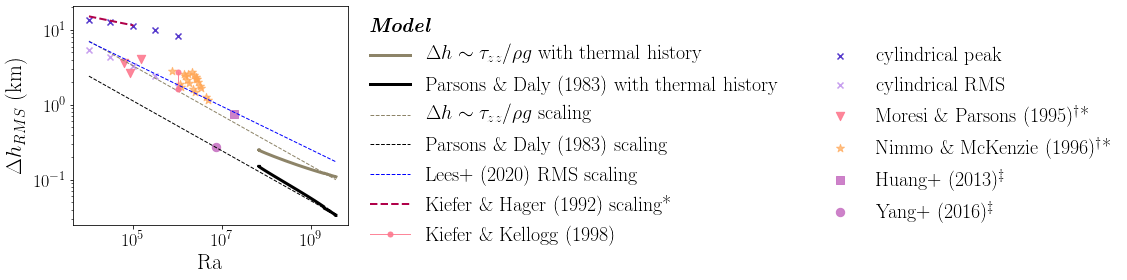

In [22]:
# make a plot of h vs. Ra - single planet evolution
# add literature model data to plot

def h_v_Ra(plots_save=False, figpath='', fname='fig', legsize=14, leg_ncol=1, legtitle=r'\textbf{\textit{Model}}', **kwargs):
    pl_list = build_solarsystem(dicts=True, run_args={'D_l0':10e3, 'T_m0':1700},
                                ident_list=['Venusbaseline'])

    # TODO: colour code by viscosity or geometry
    
    data_Moresi_h = np.array([5.8, 3.8, 5.1])*0.707
    data_Moresi_Ra = [Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100, Ra_F=2.4e6),
                     Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100,  Ra_F=1.3e6),
                     Ra_from_RaF_2(F=74e-3, l=750e3, kappa=8e-7, rho=3300, c_p=1200, dT=1100, Ra_F=1e6)]
    
    data_Nimmo_h = [2.847, 1.914, 1.729, 2.585, 2.416, 1.629, 1.955, 2.604, 2.173, 1.467, 2.217, 2.328, 2.772, 2.023, 2.225, 2.529, 1.278, 1.703, 1.789, 1.157] 
    data_Nimmo_Ra = [Ra_from_RaB(F=20e-3, l=840e3, k=3.17, Ra_B=3.95e6), # 
                     Ra_from_RaB(F=15e-3, l=760e3, k=3.17, Ra_B=3.95e6),
                     Ra_from_RaB(F=15e-3, l=695e3, k=3.17, Ra_B=3.95e6),
                     
                     Ra_from_RaB(F=20e-3, l=910e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=20e-3, l=860e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=15e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=18e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=19e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=20e-3, l=775e3, k=3.17, Ra_B=7.89e6),
                     Ra_from_RaB(F=15e-3, l=705e3, k=3.17, Ra_B=7.89e6),
              
                     Ra_from_RaB(F=20e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=21e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=25e-3, l=950e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=20e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=22e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=25e-3, l=890e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=15e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=20e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=21e-3, l=775e3, k=3.17, Ra_B=1.58e7),
                     Ra_from_RaB(F=15e-3, l=705e3, k=3.17, Ra_B=1.58e7),
              ]
    
    data_KH91_h = [7.5, 6.3, 5.1]
    data_KH91_Ra = [1e5, 3e5, 1e6]
    
    data_Yang_h = powerspectrum_RMS('benchmarks/yang_Venus/h_amplitude_m.csv', amplitude=True)*1e-3
    data_Yang_Ra = 7.3e6


    dT_m = 1500
    data_KK98_h = np.array([0.006, 0.01])*dT_m*6050*pl_list['Venusbaseline'].alpha_m # scaled from h' to km
  
    data_KK98_Ra = [1e6, 1e6]
    
    data_RMS = [2.733] # Golle RMS
    data_Ra = [Ra_from_RaB(F=15e-3, l=2665e3, k=3.17, Ra_B=3e8, dT=2969) ]# Golle RMS, assume F=15e-3
    data_label = [ r'Golle+ (2012)$^\dagger$']
    
    data_Wei_Ra = 1.8e7
    data_Wei_h = powerspectrum_RMS('benchmarks/wei_Venus/model_power_m2_b.csv')*1e-3
    
    czechfaction_RMS = [
        powerspectrum_RMS('benchmarks/benesova_Venus/3A2x1021_powerspectrum_m2.csv'),
#         powerspectrum_RMS('benchmarks/benesova_Venus/3A4x1022_powerspectrum_m2.csv'),
        powerspectrum_RMS('benchmarks/benesova_Venus/3C5x1021_powerspectrum_m2.csv'),
        powerspectrum_RMS('benchmarks/benesova_Venus/3D1x1022_powerspectrum_m2.csv')]
    czechfaction_Ra = [3.8e6, 1e6, 2.5e6]

    
    xname = {'Ra_i':('Ra', 1)}
    plot_planets = pl_list['Venusbaseline'] # planets
    
    ynames = {'dyn_top_stress':('$\Delta h_{RMS}$ (km)', 1e-3)}
    fig, ax = plot_vs_x(lplanets=plot_planets, xname=xname, ynames=ynames, set_ylim=False,
                          c='xkcd:brown grey', ls='-', lw=3,
                          label_l=r'$\Delta h \sim \tau_{zz}/\rho g$ with thermal history',
                          **kwargs)

    
    ynames = {'dyn_top_rms':('$\Delta h_{RMS}$ (km)', 1e-3)}
    fig, ax = plot_vs_x(lplanets=plot_planets, xname=xname, ynames=ynames, set_ylim=False,
                        c='k', ls='-', lw=3, 
                        label_l=r'Parsons \& Daly (1983) with thermal history',
                        fig=fig, axes=ax, **kwargs)

    
    ax.set_yscale('log')
    
    


    
    # plot Ra scaling across the board from PD and stress , i guess fixing some parameters
    pl = plot_planets
    a_rh = 2.44
    alpha = pl.alpha_m
    T_m = pl.T_m[-1]
    Ea = pl.Ea
    dT_rh = p.R_b*T_m**2/Ea
    dT_m =  pl.deltaT_m[-1]
    
    eta_m = pl.eta_m[-1]
    kappa_m = pl.kappa_m
    d_m = pl.d_m[-1]
    Ra_crit = plot_planets.Ra_crit_u
    Ra = np.logspace(4, np.log10(np.max(plot_planets.Ra_i)))
    print('our model dT_m=', dT_m, 'K; d_m', d_m*1e-3, 'km; alpha =', alpha)

    
    h_PD83_Ra = 5.4*alpha*d_m*(a_rh*dT_rh*dT_m/Ra_crit**(1/3))**0.5 * Ra**(-1/3) * 1e-3
    h_stress_Ra = 2*alpha*d_m*dT_rh * (Ra/Ra_crit)**(-1/3) * 1e-3
    
    ax.plot(Ra, h_stress_Ra, lw=1, ls='--', c='xkcd:brown grey', 
            label=r'$\Delta h \sim \tau_{zz}/\rho g$ scaling') 
    ax.plot(Ra, h_PD83_Ra, lw=1, ls='--', c='k', 
            label=r'Parsons \& Daly (1983) scaling') 
    
    # plot Lees fit free-slip (free-free) - our PD is scaled to match their RMS, exponent lower than -1/3 because dT is outside scaling
    h_rms_prime_Lees = 1.191*Ra**-0.289
    d_m = 2800e3
    dT_m = 1000
    alpha = 3e-5
    h_rms_Lees = h_rms_prime_Lees*alpha*dT_m*d_m*1e-3
    ax.plot(Ra, h_rms_Lees, lw=1, ls='--', c='b', 
            label=r'Lees+ (2020) RMS scaling') 

 
    # answer what the difference is between RMS and peak just for KH cylindrical case - 
    # load data points from model run
    df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
    h_peak_JFR = np.array(df.peak_topo)*alpha*dT_m*d_m*1e-3
    h_rms_JFR = np.array(df.RMS_topo)*alpha*dT_m*d_m*1e-3
    ax.scatter(np.array(df.Ra), h_peak_JFR, marker='x', c='xkcd:blurple', 
               label='cylindrical peak')
    ax.scatter(np.array(df.Ra), h_rms_JFR, marker='x', c='xkcd:lavender', 
               label='cylindrical RMS')
    print('h_RMS/h_peak = ',h_rms_JFR/ h_peak_JFR)
    
    
    # KH92 for Ra 10^4-10^5 constant eta
    Ra = np.logspace(4, 5)
    h_KH92 = (66*Ra**-0.121)*0.7*0.707
    ax.plot(Ra, h_KH92, lw=2, ls='--', c='xkcd:raspberry', 
            label=r'Kiefer \& Hager (1992) scaling*') 
    
    

    # RMS scatter for Moresi & Parsons  
    ax.scatter(data_Moresi_Ra, data_Moresi_h, marker='v', s=70, alpha=0.9,
               c='xkcd:carnation', 
               label=r'Moresi \& Parsons (1995)$^\dagger$*')
    
#          # plot scatter points from czech ppl
#     ax.scatter(czechfaction_Ra, np.array(czechfaction_RMS)*1e-3, marker='o', s=70, alpha=0.7,
#                c='xkcd:sunflower', 
#                label='Benesova \& Cizkova (2012)')
    
     # plot scatter points from Nimmo
    ax.scatter(data_Nimmo_Ra, np.array(data_Nimmo_h), marker='*', s=70, alpha=0.7,
               c='xkcd:pale orange', 
               label=r'Nimmo \& McKenzie (1996)$^\dagger$*')
    

    
    # plot scatter points from KK98
    ax.plot(data_KK98_Ra, data_KK98_h, marker='.', ls='-', lw=1, alpha=0.9,
               c='xkcd:carnation', ms=10,
               label=r'Kiefer \& Kellogg (1998)')

    
#     # plot scatter points from KH91
#     ax.scatter(data_KH91_Ra, np.array(data_KH91_h)*0.707, marker='x', c='xkcd:rose pink', 
#                label=r'Kiefer & Hager (1991) $\times 0.707$')
    
    
#    # plot RMS scatter points from Golle
#     for x, y, l in zip(data_Ra, data_RMS, data_label): 
#         ax.scatter(x, y, c='xkcd:orchid', marker='^', label=l, s=70)

    # RMS scatter for Wei+ 2014    
    ax.scatter(data_Wei_Ra, data_Wei_h, marker='s', s=70, alpha=0.9,
           c='xkcd:orchid', 
           label=r'Huang+ (2013)$^\ddagger$')

    
    # RMS scatter for Yang2016  
    ax.scatter(data_Yang_Ra, data_Yang_h, marker='o', s=70, alpha=0.9,
           c='xkcd:orchid', 
           label=r'Yang+ (2016)$^\ddagger$')
    


    
    legend=ax.legend(frameon=False, fontsize=legsize, loc='upper left', bbox_to_anchor= (1.05, 0.99), ncol=leg_ncol,
              borderaxespad=0, title=legtitle, )
    if legtitle is not None:
            plt.setp(legend.get_title(),fontsize=legsize)
            legend._legend_box.align = "left"
    
    if plots_save:
        fig.savefig(figpath+fname+'.pdf', bbox_inches='tight') 
    
    return fig, ax

goodname='h_comparison'
fig, ax = h_v_Ra(plots_save=False, figpath=goodfig_path, fname=goodname, labelpad=5,
                 labelsize=22, legsize=20, ticksize=18, leg_ncol=2)    


In [14]:
df = pd.read_csv('data_for_claire/stats.csv', header=0, index_col=False)
print(list(df.peak_topo))

          Ra  peak_topo  RMS_topo
0    10000.0   0.162924  0.065100
1    30000.0   0.151169  0.052041
2   100000.0   0.134570  0.038771
3   300000.0   0.118091  0.028887
4  1000000.0   0.100160  0.020558
[0.1629241411904295, 0.1511686913448569, 0.13457002958017036, 0.11809120587313232, 0.10016007370704333]


T_mf 1907.9379252948343
file urey.csv not found
file Ra_i.csv not found
file eta_m.csv not found
T_mf 1955.4457846217463
file q_sfc.csv not found
file D_l.csv not found
file T_c.csv not found
file urey.csv not found
file T_l.csv not found
file Ra_i.csv not found
file eta_m.csv not found


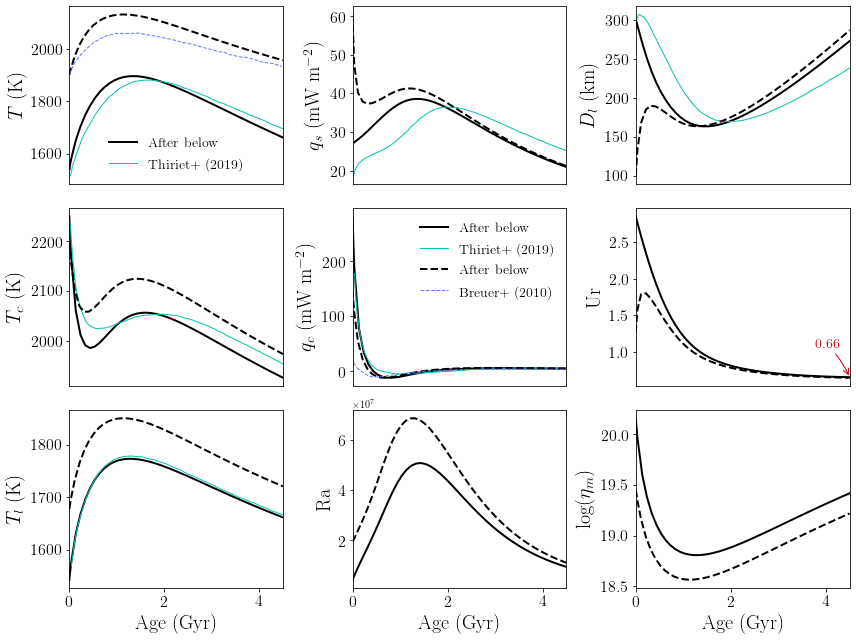

In [8]:
######  reproduce Thiriet+ 2019 Mars1

names = {'T_avg':('$T_{avg}$ (K)',1), 
         'q_sfc':('$q_{s}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'T_c':('$T_c$ (K)', 1), 
         'q_core':('$q_{c}$ (mW m$^{-2}$)', 1e3), 
         'urey':('Ur',1),
         'T_l':('$T_l$ (K)',1), 
         'Ra_i':('Ra',1), 
         'eta_m':('$\eta_m$',1),
        }
    
goodname='thermal_Mars1'
goodfig_path = 'latex/report-firstyr/figs/'
fig, axes = benchmark_thermal_plots('Mars1', names=names, compare_dir='benchmarks/thiriet_Mars1', 
                                    #compare_dir=['benchmarks/thiriet_Mars1', 'benchmarks/breuer_Mars'], 
                                    fig_path=goodfig_path,
                                    plots_save=True, print_tf=True, legsize=14, ncols=3, labelsize=20,
                                    annotate_colour='xkcd:scarlet', ticksize=16, fname=goodname,
                                    show_qsfc_error=False,title='',
#                                     title='Mars-like planet', 
                                    label='After below', 
                                    cmp_label='Thiriet+ (2019)',
                                    #cmp_label=['Thiriet+ (2019)', 'Breuer+ (2010)'],
                                    fontname='CMU Serif Roman',
                                    cmp_line_args={'c':'xkcd:turquoise', 'lw':1, 'ls':'-'},
                                                  
#                                     cmp_line_args=[{'c':'xkcd:turquoise', 'lw':1, 'ls':'--'},
#                                                   {'c':'xkcd:cornflower', 'lw':1, 'ls':'--'}]
                                   )



# expect q_sfc to be off by <=4.5 mW m^-3 average without PDE

# repeat for second comparison
names = {'T_m':('$T$ (K)',1), 
         'q_sfc':('$q_{s}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'T_c':('$T_c$ (K)', 1), 
         'q_core':('$q_{c}$ (mW m$^{-2}$)', 1e3), 
         'urey':('Ur',1),
         'T_l':('$T_l$ (K)',1), 
         'Ra_i':('Ra',1), 
         'eta_m':('log($\eta_m$)',1), 
        }
fig, axes = benchmark_thermal_plots('Mars_Breuer', compare_dir='benchmarks/breuer_Mars', 
                                    fig_path=goodfig_path, fig=fig, axes=axes,
                                    plots_save=True,  legsize=14, ncols=3, labelsize=20,
                                    annotate_colour='xkcd:scarlet', ticksize=16, fname=goodname,
                                    label='After below', names=names,
                                    cmp_label='Breuer+ (2010)', legax=4, title='',
#                                     title='Mars-like planet', 
                                    fontname='CMU Serif Roman',
                                    line_args={'c':'k', 'lw':2, 'ls':'--'},
                                    cmp_line_args={'c':'xkcd:cornflower', 'lw':1, 'ls':'--'},
                                   )

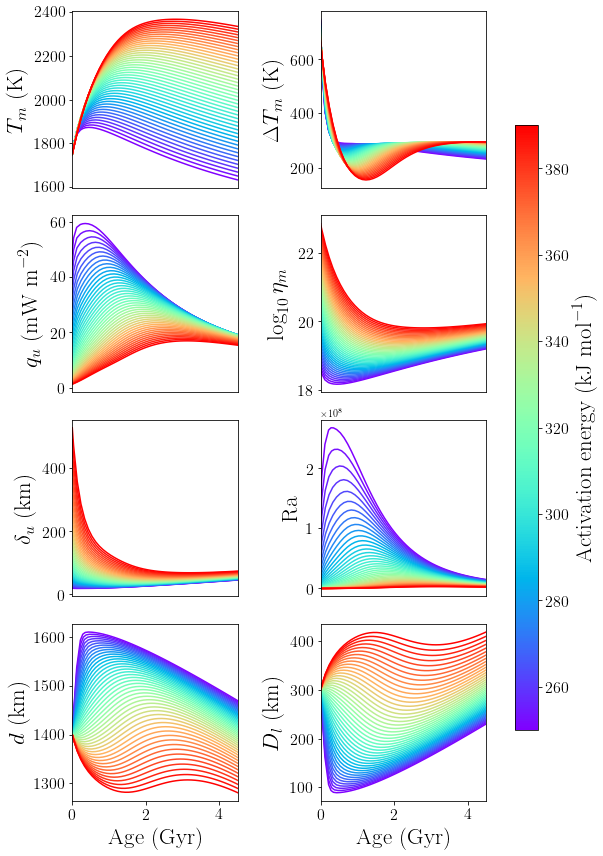

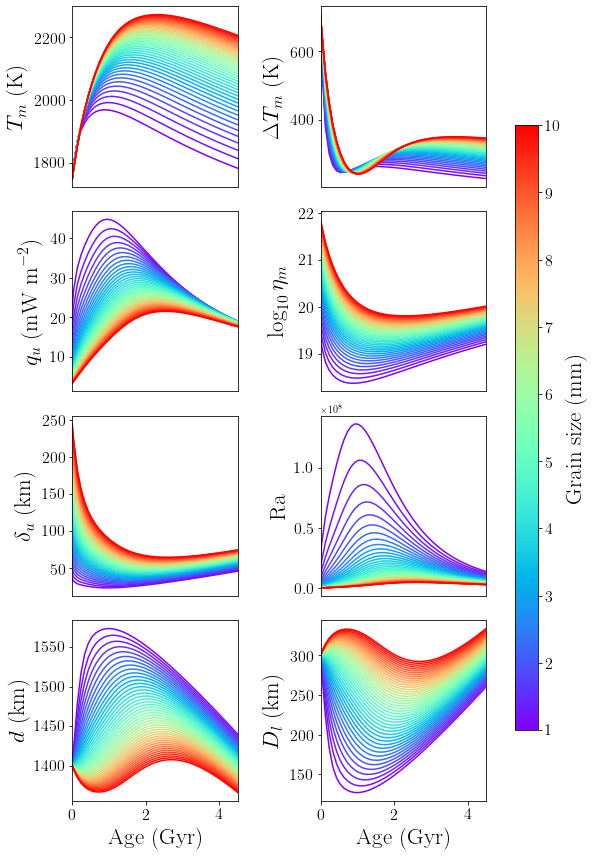

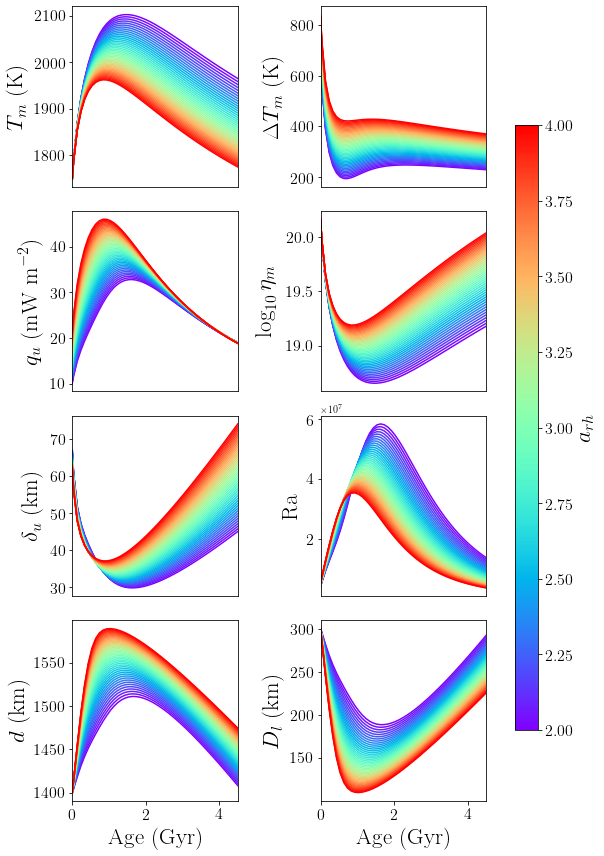

In [6]:
######  test effect of changing rheological parameters
def plot_rheology_tradeoff(save=False, fig_path='figs/', fname='fig', zmin=None, zmax=None, 
                           zname=None, zlabel=None, clabelpad=1, zscale=1, res=30, **kwargs):
    names = {'T_m':('$T_m$ (K)',1), 
             'deltaT_m':(r'$\Delta T_m$ (K)', 1),
             'q_ubl':('$q_{u}$ (mW m$^{-2}$)',1e3), 
             'eta_m':('$\log_{10} \eta_m$',1), 
             'TBL_u':('$\delta_{u}$ (km)',1e-3),
             'Ra_i':('Ra',1),
             'd_m':('$d$ (km)',1e-3),
             'D_l':('$D_l$ (km)',1e-3),
            # 'urey':('Ur',1)
            }

    h = rh.grain_size(A_rh=8.7e15, eta_0=1e21, Ea=300e3, T_ref=1600, m=2.5, B_rh=0.5e-9, mu=80e9)
#     print('h =',h*1e3, 'mm for T_ref = 1600 and eta_ref = 1e21')

    #defaults = eval('ins.Venusbaseline_in')
    defaults = dict(
     Alb=None, 
     H_0=4e-12, # final radiogenic heating in W/kg
     X_K=305, # initial abundance of K in wt ppm
     X_U=16e-3, # initial abundane of U in wt ppm 
     X_Th=56e-3, # initial abundance of Th in wt ppm 
     L=None, 
     Ra_crit_u=450, 
     R_p0=3400e3, 
     R_c0=1700e3,
     alpha_m=2.5e-5, # thermal expansivity
     k_m=4, # silicate thermal conductivity
     CMF=0.24, # not used
     rho_c=7200, # core density
     rho_m=3500, # mantle density 
     rho_lith=None, 
     c_m=1142, #<----??? TODO: check if you need constant volume c_p
     c_c=840, # specific heat for core in J/K/kg
     k_lm=4, # thermal conduvtivity lower mantle
     beta_u=None, # defaults to 1/3
     beta_c=None, # defaults to 1/3 
     a_rh=2.44, # for beta=1/3 
     Ea=300e3, # activation energy in J for viscosity law
     T_s=250, # fixed surface temp in K
     M_p=6.39e23, # only used for gravity in this case
     sma=None, 
     g_sfc = 3.7,
    mu=80e9, A_rh=8.7e15, 
    h_rh=2.07e-3,
    B_rh=0.5e-9, m_rh=2.5
     )
    run_kwargs = eval('ins.Venusbaseline_run')
    z_vec = np.linspace(zmin, zmax, num=res)
    cols = colorize(z_vec, cmap='rainbow')[0]
    for ii, zz in enumerate(z_vec):
        defaults.update({zname:zz})
        pl = tp.TerrestrialPlanet(**defaults)
        pl = therm.solve(pl, **run_kwargs) # T_m, T_c, D_l
        pl = top.topography(pl=pl, C=2.44, **run_kwargs)
        if ii==0:
            fig=None
            axes=None
        fig, axes = plot_output(pl, names, ncols=2, plots_save=save, fig=fig, axes=axes, 
                                fig_path=fig_path, legend=False, 
                                title='', line_args={'c':cols[ii]}, **kwargs)


    # plt.tight_layout()
    sc = fig.gca().scatter(None, None, vmin=zmin, vmax=zmax, cmap='rainbow')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=zmin*zscale, vmax=zmax*zscale))
    sm._A = []
    fig.subplots_adjust(right=0.85, wspace=0.5)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.04, 0.7])
    fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_ylabel(zlabel, fontsize=labelsize, labelpad=clabelpad)
    cbar_ax.tick_params(axis='y', labelsize=ticksize) 
    if save:
        fig.savefig(fig_path+fname+'.pdf', bbox_inches='tight')
    return fig, axes


save=False
res=45
labelsize=23
ticksize=16
clabelpad=4
fig, axes = plot_rheology_tradeoff(save=save, res=res, fig_path=goodfig_path, fname='Ea-effect-evol', 
                                   zlabel='Activation energy (kJ mol$^{-1}$)', zname='Ea', 
                                   labelsize=labelsize, ticksize=ticksize, clabelpad=clabelpad,
                                   zmin=250e3, zmax=390e3, zscale=1e-3)

fig, axes = plot_rheology_tradeoff(save=save, res=res, fig_path=goodfig_path, fname='h-effect-evol', 
                                   zlabel='Grain size (mm)', zname='h_rh', 
                                   labelsize=labelsize, ticksize=ticksize,  clabelpad=clabelpad,
                                   zmin=1e-3, zmax=10e-3, zscale=1e3)

fig, axes = plot_rheology_tradeoff(save=save, res=res, fig_path=goodfig_path, fname='a_rh-effect-evol', 
                                   zlabel='$a_{rh}$', zname='a_rh', 
                                   labelsize=labelsize, ticksize=ticksize,  clabelpad=clabelpad,
                                   zmin=2, zmax=4, zscale=1)

In [63]:
def d_m(CMF, M_p, D_l0):
    return (1.07 - 0.121*CMF)*M_p**(1/3.7)*p.R_E - D_l0 - (1.07*CMF**0.5 - 0.121*CMF**(3/2))*M_p**(1/3.7)*p.R_E

print('d at 6 M_E', d_m(0.3, 6, 150e3)*1e-3, 'km')
print('d at 0.1 M_E', d_m(0.3, 0.1, 150e3)*1e-3, 'km')


pl_baseline = bulk_planets(N=2, name='CMF', mini=0.07829, maxi=0.544, visc_type='KW', like='Earthbaseline',
                            t_eval=None, random=False)

d at 6 M_E 4684.1285804421805 km
d at 0.1 M_E 1448.5888473862333 km
d_m with 150-km lid 4684.120954364214 km
d_m with 150-km lid 1448.0140716232136 km


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:483: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


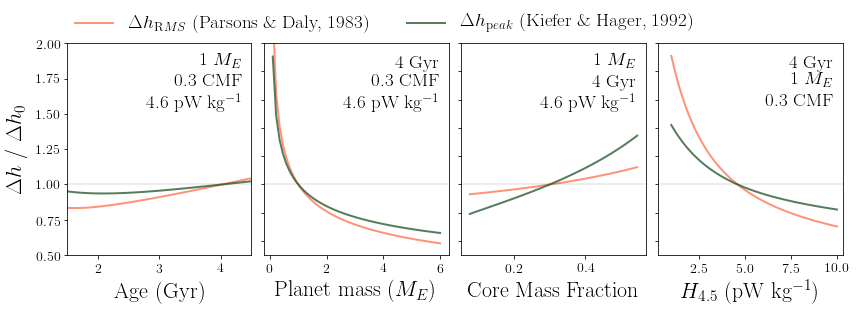

In [25]:
def plot_h_relative(plots_save=False, defaults='Earthbaseline', fname='fig', fig_path='figs/', wspace=None, 
                    snap=4.5,
                    fig=None, axes=None, h_param='dyn_top_stress', legend=False, legsize=12, **plot_kwargs):
    pl_kwargs =  eval('ins.'+defaults+'_in') 
    if axes is None:
        fig, axes = plt.subplots(1, 4, figsize=(12,4))
    
    pl_baseline = bulk_planets(N=1, name='M_p', mini=1*p.M_E, maxi=1*p.M_E, visc_type='KW', 
                                t_eval=None, random=False, T_m0=1750, T_c0=2250, D_l0=100e3, tf=4.5, 
                                **pl_kwargs)[0]
    h_baseline = eval('pl_baseline.'+h_param)
    it = min(enumerate(pl_baseline.t), key=lambda x: abs(snap - x[1]*p.sec2Gyr))[0] # get time index nearest to desired snap given in Gyr
                    
#     print('\n \n h_param', h_param)
#     print(h_baseline[0], h_baseline[-1], 'm')

    # time/age variation
    fig, ax = plot_vs_x(legend=legend, legsize=legsize,
                          lplanets=pl_baseline, xname={'t':('Age (Gyr)', p.sec2Gyr)}, set_xlim=True,
                          ynames={h_param:('$\Delta h$ / $\Delta h_0$  ', h_baseline[it]**-1)}, 
                          plots_save=False, fig=fig, axes=axes[0], xmin=1.5, xmax=4.5, **plot_kwargs)
    ax.axhline(y=1, lw=0.1, c='k', alpha=0.7)
    if legend:
        ax.text(0.95, 0.95,'{:1.0f}'.format(pl_baseline.M_p/p.M_E)+' $M_E$ \n 0.3 CMF \n 4.6 pW kg$^{-1}$', 
                fontsize=legsize,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform = ax.transAxes)

    # mass variation
    planets_mass = bulk_planets(N=50, name='M_p', mini=0.1*p.M_E, maxi=6*p.M_E, visc_type='KW', 
                                t_eval=pl_baseline.t, random=False, T_m0=1750, T_c0=2250, D_l0=100e3, tf=4.5, 
                                **pl_kwargs)
    fig, ax = plot_vs_x(
                          lplanets=planets_mass, xname={'M_p':('Planet mass ($M_E$)', p.M_E**-1)}, 
                          ynames={h_param:('', h_baseline**-1)}, snap=snap,
                          plots_save=False, fig=fig, axes=axes[1], ylabel=False, **plot_kwargs)
    ax.axhline(y=1, lw=0.1, c='k', alpha=0.7)
    if legend:
        ax.text(0.95, 0.95,str(snap)+' Gyr \n 0.3 CMF \n 4.6 pW kg$^{-1}$', fontsize=legsize,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform = ax.transAxes)
    
    
    # CMF variation
    planets_CMF = bulk_planets(N=50, name='CMF', mini=0.07829, maxi=0.544,  visc_type='KW', 
                                t_eval=pl_baseline.t, random=False,  **pl_kwargs)
    fig, ax = plot_vs_x(
                          lplanets=planets_CMF, xname={'CMF':('Core Mass Fraction',1)}, 
                          ynames={h_param:('', h_baseline**-1)}, snap=snap,
                          plots_save=False, fig=fig, axes=axes[2], ylabel=False, **plot_kwargs)
    ax.axhline(y=1, lw=0.1, c='k', alpha=0.7)
    if legend:
        ax.text(0.95, 0.95,'{:1.0f}'.format(pl_baseline.M_p/p.M_E)+' $M_E$ \n'+str(snap)+' Gyr \n 4.6 pW kg$^{-1}$', fontsize=legsize,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform = ax.transAxes)
    
    
    
    # H0 variation
    planets_H0 = bulk_planets(N=50, name='H_0', mini=1e-12, maxi=10e-12, visc_type='KW', 
                                t_eval=pl_baseline.t, random=False, T_m0=1750, T_c0=2250, D_l0=100e3, tf=4.5, 
                                **pl_kwargs)
    fig, ax = plot_vs_x(xmin=0.3, xmax=10.3, set_xlim=True,
                          lplanets=planets_H0, xname={'H_0':('$H_{4.5}$ (pW kg$^{-1}$)', 1e12)}, 
                          ynames={h_param:('', h_baseline**-1)}, snap=snap, 
                          plots_save=False, fig=fig, axes=axes[3], ylabel=False, **plot_kwargs)
    ax.axhline(y=1, lw=0.1, c='k', alpha=0.7)
    if legend:
        ax.text(0.95, 0.95,str(snap)+' Gyr \n'+'{:1.0f}'.format(pl_baseline.M_p/p.M_E)+' $M_E$ \n 0.3 CMF', fontsize=legsize,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform = ax.transAxes)
        
    plt.subplots_adjust(wspace=wspace)
    if plots_save:
        plt.savefig(fig_path+fname+'.pdf', bbox_inches='tight') 
    return fig, axes
    
def plot_h_relative_cmp(defaults='Earthbaseline', plots_save=False, fig_path='figs/', fname='fig', 
                        models=['dyn_top_rms','dyn_top_KH','dyn_top_stress'],
                        labels=['Parsons \& Daly (1983)','Kiefer \& Hager (1992)',
                                r'$\Delta h \sim \alpha \Delta T_{rh} \delta_{bl}$'],
                        c=['xkcd:neon red','xkcd:bright yellow','xkcd:golden yellow'],
                        fig=None, axes=None, **kwargs):
    legend=False
    for ii, h_param in enumerate(models):
        if ii==len(models)-1:
            legend=True
        fig, axes = plot_h_relative(defaults=defaults, fig=fig, axes=axes,
                            h_param=models[ii], label_l=labels[ii], 
                            c=c[ii], legend=legend, **kwargs)
    if plots_save:
        fig.savefig(fig_path+fname+'.pdf', bbox_inches='tight') 
    return fig, axes
#xkcd:tea

fig, axes=plot_h_relative_cmp(snap=4, alpha=0.8, wspace=0.07, legsize=19, ticksize=14, labelsize=22, 
                              ymin=0.5, ymax=2, lw=2, #legtitle=r'\textbf{\textit{Model}}', 
                              labelpad=7, legendtop=True,
                             plots_save=True, fname='relative_h', fig_path=goodfig_path,
                             models=['dyn_top_rms','dyn_top_KH'],
                             labels=['$\Delta h_{\mathrm RMS}$ (Parsons \& Daly, 1983)',
                                     '$\Delta h_{\mathrm peak}$ (Kiefer \& Hager, 1992)',
                                r'$\Delta h \sim \alpha \Delta T_{rh} \delta_{bl}$'],
                        c=['xkcd:melon','xkcd:pine'],)

# variation with surface T_eq is on the order of 10 ppm

V_ocean0 = 0.8228307366788303
y max_ocean 0.31799116543703476 1.64625904327308
y max_ocean 1.2100004198141847 0.687895692793926
y max_ocean 1.4885913588523154 1.0


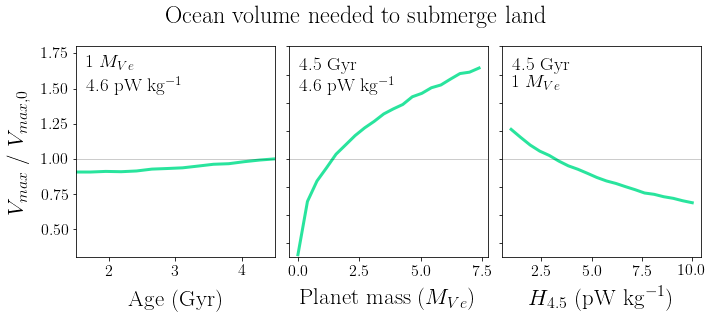

In [6]:
# ocean volume - as baseline planet use Huang Venus case 15

def peak_from_spectrum(power, norm='4pi', lmax=40, n=1):
    ii=0
    h_peak = []
    while ii<n:
        coeffs_global = pyshtools.SHCoeffs.from_random(power, normalization=norm)
        topo = coeffs_global.expand(lmax=lmax)
        h_peak.append(np.max(topo.data)) # in m
        ii+=1
    return np.mean(h_peak)

def load_spectrum(fpath='', fname=''):
    df = pd.read_csv(fpath+fname, header=None, names=['l', 'S_l'], index_col=False)
    degrees = df['l']
    power = df['S_l']
    # todo : find nearest l for imperfect digitization
    return power

def ocean_vol(h_peak, R_p=p.R_E):#6051.88e3):
    EO = 1.35e9 * 1000**3
    vol = 4/3*np.pi*((R_p + h_peak)**3 - R_p**3)
    return vol/EO

def scale_spectrum(phi0, pl, pl0, h_func=None, snap=4.5):
    # phi0 : digitized baseline spectrum
    it = min(enumerate(pl.t), key=lambda x: abs(snap - x[1]*p.sec2Gyr))[0] # get time index nearest to desired snap given in Gyr
                    
    if h_func is None:
        ratio = (pl.d_m * pl.T_m**2 * pl.Ra_i**(-1/3)) / (pl0.d_m * pl0.T_m**2 * pl0.Ra_i**(-1/3)) # = phi / phi0
    sqrtphi = np.sqrt(phi0)*ratio[it]
    return sqrtphi**2

def oceans_plot(n_stats=1000, wspace=0.5, fig_path='figs/', snap=4.5, legsize=16, **plot_kwargs):

    ident = 'Venusbaseline'
    pl0 = build_planet(ident='Venusbaseline', run_args=None, 
                       update_args={'k_m':3.206, 'alpha_m':2e-5, 'T_s':730},)
    pl_list = bulk_planets(N=20, name='M_p', mini=0.01*p.M_E, maxi=6*p.M_E, like=ident, 
                           update_kwargs={'k_m':3.206, 'alpha_m':2e-5, 'T_s':730},
                           t_eval=pl0.t, random=False)
    d_ocean_Earth = 3.7e3
    phi0 = load_spectrum(fpath = 'benchmarks/wei_Venus/',fname = 'model_power_m2_b.csv')
    h_peak0 = peak_from_spectrum(phi0, n=n_stats)
    V_ocean0 = ocean_vol(h_peak0)
    pl0.max_ocean = V_ocean0
    print('V_ocean0 =',V_ocean0)

    for pl in pl_list:
        phi = scale_spectrum(phi0, pl, pl0)
        h_peak = peak_from_spectrum(phi, n=n_stats)
    #     print('h_peak', h_peak)
        answer = ocean_vol(h_peak, R_p=pl.R_p)
    #     print('ocean_vol', answer)
        pl.max_ocean = answer # in EO

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle('Ocean volume needed to submerge land', fontsize=24, y=1.1)

    fig, ax = plot_vs_x(set_xlim=False,fig=fig, axes=axes[1],
                          lplanets=pl_list, ncol=1, ylabel=False, 
                          xname={'M_p':(r'Planet mass ($M_{Ve}$)', 4.867e24**-1)}, 
                          ynames={'max_ocean':(r'$V_{max}/V_{max, Ve}$', V_ocean0**-1)}, 
                          snap=snap, **plot_kwargs)


    ax.axhline(y=1, lw=0.5, c='k', alpha=0.4)
    ax.text(0.05, 0.95,str(snap)+' Gyr \n 4.6 pW kg$^{-1}$', fontsize=legsize,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)


    planets_H0 = bulk_planets(N=20, name='H_0', mini=1e-12, maxi=10e-12, like=ident, 
                           update_kwargs={'k_m':3.206, 'alpha_m':2e-5, 'T_s':730},
                           t_eval=pl0.t, random=False)

    for pl in planets_H0:
        phi = scale_spectrum(phi0, pl, pl0)
        h_peak = peak_from_spectrum(phi, n=n_stats)
    #     print('h_peak', h_peak)
        answer = ocean_vol(h_peak, R_p=pl.R_p)
    #     print('ocean_vol', answer)
        pl.max_ocean = answer # in EO

    fig, ax = plot_vs_x(#xmin=0.3, xmax=10.3, set_xlim=True,
                          lplanets=planets_H0, xname={'H_0':('$H_{4.5}$ (pW kg$^{-1}$)', 1e12)}, 
                          ynames={'max_ocean':(r'$V_{max}/V_{max, Ve}$', V_ocean0**-1)}, 
                          snap=snap, ylabel=False, 
                          fig=fig, axes=axes[2], **plot_kwargs)

    ax.axhline(y=1, lw=0.5, c='k', alpha=0.4)
    ax.text(0.05, 0.95,str(snap)+' Gyr \n'+'{:1.0f}'.format(pl0.M_p/4.867e24)+' $M_{Ve}$', fontsize=legsize,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)


    # plt.savefig(fig_path+'ocean_vol.pdf', bbox_inches='tight') 

    pl = pl_list[3]
    pl0 = tp.TerrestrialPlanet(d_m=pl.d_m[-1], T_m=pl.T_m[-1], Ra_i=pl.Ra_i[-1])
    times = np.linspace(0.1, 4.5, num=20)
    ocean = []
    for snap in times:
        phi = scale_spectrum(phi0, pl, pl0, snap=snap)
        h_peak = peak_from_spectrum(phi, n=n_stats)
        answer = ocean_vol(h_peak, R_p=pl.R_p)
    #     print('ocean_vol', answer)
        ocean.append(answer) # in EO
    pl.max_ocean = np.array(ocean)
    pl.t = times
    fig, ax = plot_vs_x(set_xlim=True, xmin=1.5, xmax=4.5, 
                        fig=fig, axes=axes[0],
                          lplanets=pl, ncol=1,
                          xname={'t':(r'Age (Gyr)', 1)}, 
                          ynames={'max_ocean':(r'$V_{max}$ / $V_{max, 0}$', pl.max_ocean[-1]**-1)}, **plot_kwargs)
    ax.axhline(y=1, lw=0.5, c='k', alpha=0.4)
    ax.text(0.05, 0.95,'{:1.0f}'.format(pl0.M_p/4.867e24)+' $M_{Ve}$ \n 4.6 pW kg$^{-1}$', fontsize=legsize,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)
    
    
    plt.subplots_adjust(wspace=wspace)
    plt.savefig(fig_path+'ocean_vol.pdf', bbox_inches='tight') 

oceans_plot(n_stats=1000, labelsize=23, ticksize=16, wspace=0.07, fig_path=goodfig_path, legsize=19, 
            c='xkcd:aqua green', alpha=0.9, lw=3, ymin=0.3, ymax=1.8, labelpad=10, set_ylim=True)

Text(0, 0.5, 'mass')

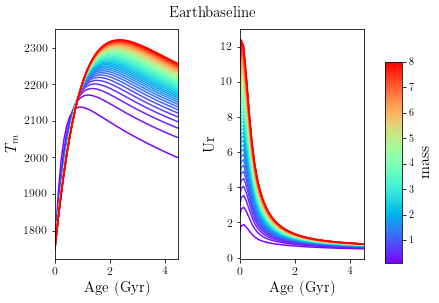

In [34]:
planets_mass = bulk_planets(N=50, name='M_p', mini=0.1*p.M_E, maxi=8*p.M_E, like='Earthbaseline',
                           random=False)
fig, axes = plt.subplots(1,2)
c = colorize(np.linspace(0.1*p.M_E, 8*p.M_E), cmap='rainbow')[0]
for ii, pl in enumerate(planets_mass):
    fig, axes = plot_output(pl, ncols=2,legend=False,
                            names={'T_m':('$T_m$', 1), 'urey':('Ur', 1)}, 
                            line_args={'c':c[ii]},
                            plots_save=False, fig=fig, axes=axes)
sc = fig.gca().scatter(None, None, vmin=0.1*p.M_E, vmax=8*p.M_E, cmap='rainbow')
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=0.1, vmax=8))
sm._A = []
fig.subplots_adjust(right=0.85, wspace=0.5)
cbar_ax = fig.add_axes([0.9, 0.15, 0.04, 0.7])
fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('mass', fontsize=16)

R_c 3513.9671967624718 km
T_mf 2126.713960090746


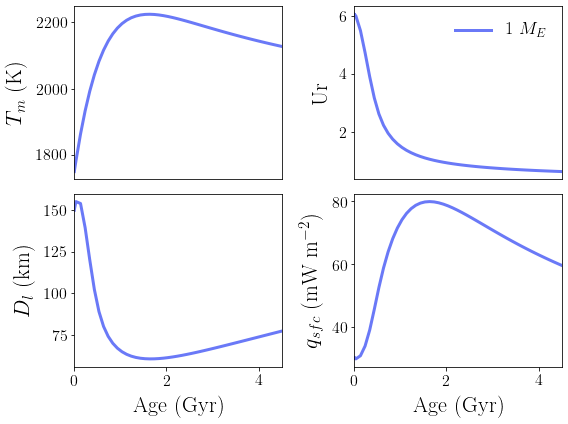

In [9]:

names = {'T_m':('$T_m$ (K)',1), 'urey':('Ur',1),
         'D_l':('$D_l$ (km)',1e-3),
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
        }
fig, axes = benchmark_thermal_plots('Earthbaseline', model_update_args={'D_l0':150e3},
                                    names=names, compare_dir=None, 
                                    fig_path=fig_path, labelpad=7,
                                    plots_save=False,  legsize=18, ncols=2, labelsize=22,
                                    annotate_colour='xkcd:scarlet', ticksize=16, fname='thermal_1ME_slides',
                                    label='1 $M_E$', legax=1, title='',
                                    fontname='CMU Serif Roman',
                                    line_args={'c':'xkcd:cornflower', 'lw':3, 'ls':'-'},
                                   )
plt.subplots_adjust(wspace=0.35)

/home/claire/Works/exo-top/thermal.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  return ((alpha_m*rho_m*g*np.absolute(dT))/(Ra_crit*kappa_m*eta_m))**(1/3)


T_mf 1285.172634601637


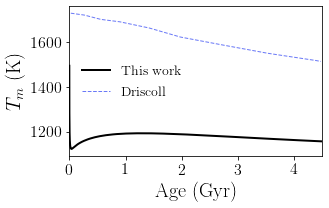

In [5]:
######  reproduce drisvool
names = {'T_l':('$T_m$ (K)',1)
            }
goodname='thermal_Hauck'
goodfig_path = 'latex/report-firstyr/figs/'
fig, axes = benchmark_thermal_plots('Mars_Hauck', 
                                    compare_dir='benchmarks/hauck_Mars', 
                                    fig_path=goodfig_path,
                                    plots_save=True, print_tf=True, legsize=14, ncols=3, labelsize=20,
                                    annotate_colour='xkcd:scarlet', ticksize=16, fname=goodname,
                                    title='', label='This work', names=names,
                                    cmp_label='Hauck', 
                                    fontname=['CMU Serif Roman'], suptitlepad=1.08,
                                    cmp_line_args={'c':'xkcd:cornflower', 'lw':1, 'ls':'--'})

# making separete ones for each comparison



In [4]:
######  reproduce driscoll bercovivi venus - no don't do this because no stagnant lid
names = {'T_m':('$T_m$ (K)',1), 
             'H_rad':('$H_{rad}$ (TW)',1e12),
         'Ur':('Ur',1),
            }
goodname='thermal_Venus_Driscoll'
goodfig_path = 'latex/report-firstyr/figs/'
fig, axes = benchmark_thermal_plots('Venus_Driscoll', 
                                    compare_dir='benchmarks/venus_Driscoll', 
                                    fig_path=goodfig_path,
                                    plots_save=True, print_tf=True, legsize=14, ncols=2, labelsize=20,
                                    annotate_colour='xkcd:scarlet', ticksize=16, fname=goodname,
                                    title='Mars-like planet', label='This work', names=names,
                                    cmp_label='Driscoll & Bercovici (2014)', 
                                    fontname=['CMU Serif Roman'], suptitlepad=1.08,
                                    cmp_line_args={'c':'xkcd:cornflower', 'lw':1, 'ls':'--'})

# making separete ones for each comparison



/home/claire/Works/exo-top/thermal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
/home/claire/Works/exo-top/thermal.py:64: RuntimeWarning: divide by zero encountered in true_divide
  c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
/home/claire/Works/exo-top/thermal.py:66: RuntimeWarning: invalid value encountered in multiply
  return 3/(R_p**3 - R_c**3)*((T_m/3)*(R_l**3 - R_c**3) - a0/(30*k_m)*(R_p**5 - R_l**5) + c1/(2*k_m)*(R_p**2 - R_l**2)  + c2/3*(R_p**3 - R_l**3))
/home/claire/Works/exo-top/thermal.py:145: RuntimeWarning: divide by zero encountered in true_divide
  c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
/home/claire/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:111: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/home/claire/Works/exo-top/rheology.py:9: RuntimeWarning: divi

ValueError: could not broadcast input array from shape (3,1) into shape (3)

In [7]:
######  reproduce Thiriet+ 2019 Moon1
Moon1 = tp.TerrestrialPlanet(M_p = 7.34767309e22,
                            R_p0 = 1740e3,
                            R_c0 = 390e3,
                            Ra_crit_u = 450,
                            rho_m = 3300,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.346, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.44,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            T_s = 250,
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            X_K = 83, # initial abundance of K in wt ppm 
                            X_U = 33e-3, # initial abundane of U in wt ppm 
                            X_Th = 125e-3, # initial abundance of Th in wt ppm 
                            H_0 = 7e-12, # radiogenic heating in W/kg at t_f
                            ident = 'Moon1'
                            )
kwargs = dict(T_m0=1750, T_c0=2000, D_l0=445e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params
Moon1 = therm.solve(Moon1, **kwargs)
pl = Moon1
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)

names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(f_Moon1, plot_snapshots=[0, 1, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
# plot_output(Moon1, names, ncols=2, plots_save=save, compare_dir='benchmarks/thiriet_Moon1', 
#             fig_path=fig_path, tspan=(0, 4.5), **kwargs)


In [8]:
######  reproduce Thiriet+ 2019 Mercury1
Mercury1 = tp.TerrestrialPlanet(M_p = 3.285e23,
                                R_p0 = 2440e3,
                                R_c0 = 2010e3,
                                Ra_crit_u = 450,
                                rho_m = 3500,
                                rho_c = 7200,
                                c_m = 1142,
                                c_c = 840,
                                beta_u = 0.335, # defaults to 1/3
                                beta_c = None, # defaults to 1/3
                                a_rh = 2.54, 
                                k_m = 4,
                                k_lm = 4,
                                alpha_m = 2.5e-5,
                                T_s = 440,
                                # viscosity 
                                Ea = 300e3,
                                eta_0 = 1e21,
                                T_ref = 1600,
                                X_K = 400, # initial abundance of K in wt ppm 
                                X_U = 28e-3, # initial abundane of U in wt ppm 
                                X_Th = 50e-3, # initial abundance of Th in wt ppm 
                                H_0 = 5e-12, # radiogenic heating in W/kg at t_f
                                ident='Mercury1'
                            )
kwargs = dict(T_m0=1750, T_c0=2000, D_l0=137e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params
Mercury1 = therm.solve(Mercury1, **kwargs)
pl = Mercury1
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(Mercury1, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
# plot_output(Mercury1, names, tspan=(0, 2), ncols=2, plots_save=save, fig_path=fig_path,
#             compare_dir='benchmarks/thiriet_Mercury1', **kwargs)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


(<Figure size 864x1080 with 13 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6904564410>,
       dtype=object))

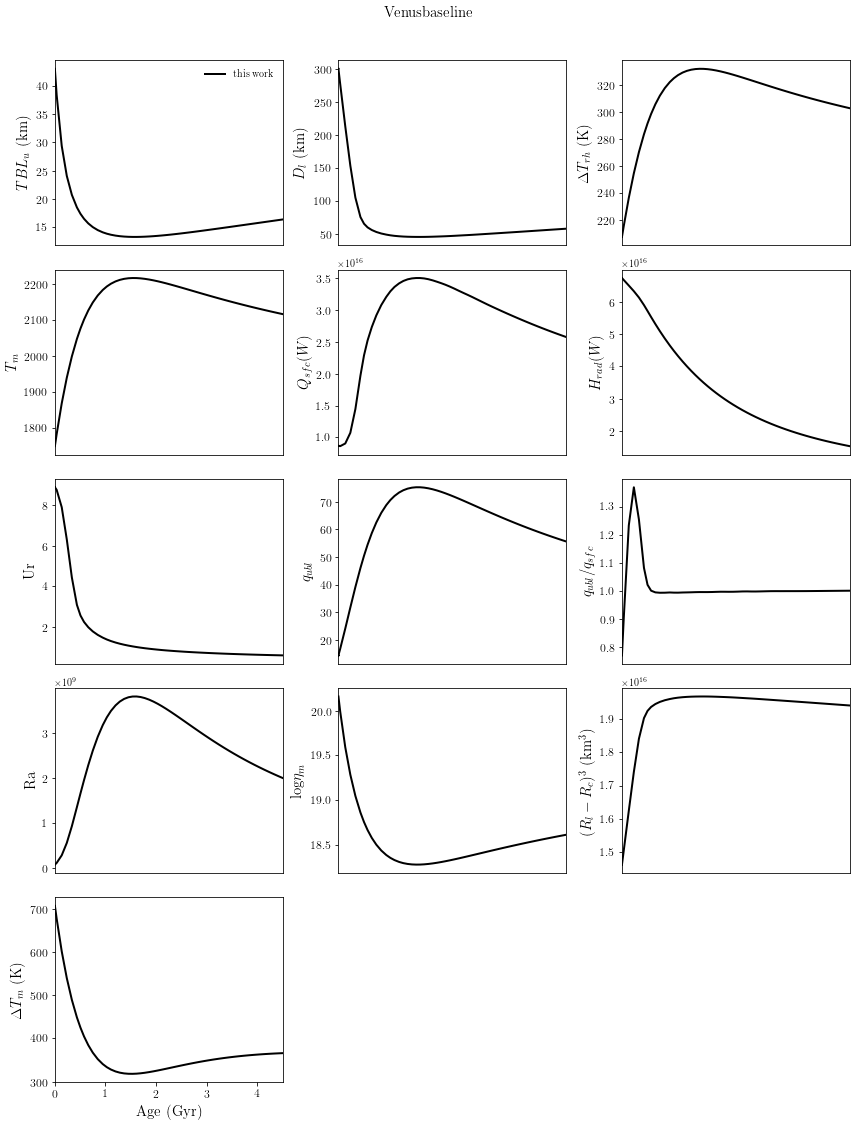

In [11]:
# testing evolutions
pl = build_solarsystem(run_args={'T_m0':1750, 'D_l0':300e3},
                        ident_list=['Venusbaseline'])[0]

names = {'TBL_u':('$TBL_u$ (km)',1e-3), 
         'D_l':('$D_l$ (km)',1e-3),
         'T_m - pl.T_l':('$\Delta T_{rh}$ (K)',1), 
         'T_m':('$T_m$', 1),
         'Q_sfc':('$Q_{sfc} (W)$', 1e3),
         'H_rad_m':('$H_{rad} (W)$', 1e3),
         'urey':('Ur', 1),
         'q_ubl':('$q_{ubl}$', 1e3),
         'q_ubl/pl.q_sfc':('$q_{ubl}/q_{sfc}$', 1),
         'Ra_i':('Ra', 1),
         'eta_m':('log$\eta_m$', 1),
         'd_m**3':('($R_l - R_c)^3$ (km$^3$)', 1e-3),
         'deltaT_m':('$\Delta T_m$ (K)',1), 
        }
save=False
# snaps(pl, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
plot_output(pl, names, ncols=3, plots_save=save, fig_path=fig_path)


In [36]:
np.mean(np.cos(np.linspace(0, np.pi*2)))

0.01999999999999991

In [10]:
######  extrapolate Thiriet+ 2019 to Earth
Earth = tp.TerrestrialPlanet(M_p = p.M_E, 
                            CMF = 0.3,
                            sma = 1,
                            L=1,
                            Alb=0,
                            Ra_crit_u = 450,
                            rho_m = 3500,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.335, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.54 ,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            # viscosity 
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                            ident = 'Earth'
                            )                  
kwargs = dict(T_m0=1750, T_c0=2250, D_l0=600e3, t0=0, tf=4.5, visc_type='Thi', complexity=3)
Earth = therm.solve(Earth, **kwargs)
pl = Earth
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(Earth, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, **kwargs)
# plot_output(Earth, names, ncols=2, plots_save=save, fig_path=fig_path,
#             **kwargs)


In [ ]:
###### reproduce Nimmo & McKenzie 1997 

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800
alpha_m = 4e-5
k_m = 3.11
k_lm = 3.11
beta = 0.25
T_s = 450+273
visc_type='constant'


In [ ]:
###### reproduce Kite+ 2009 stagnant lid model (melting?) 

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
###### reproduce Venus fig 6 in Driscoll & Bercovici FAILED 
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737


In [219]:
# check radiogenic heating rates

c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, 56/16, 305e3/16])
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5]
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec
tf = 4.5e9*years2sec
h_0 = h_rad(0, tf, 4e-12, c_n, p_n, lambda_n)
h_f = h_rad(4.5e9*years2sec, tf, 4e-12, c_n, p_n, lambda_n)
print('H_t0 =', h_0, 'W/kg =', h_0*6.39e23*1e-11, 'TW')
print('H_tf =', h_f, 'W/kg =', h_f*6.39e23*1e-11, 'TW')

H_t0 = 2.217642585962431e-11 W/kg = 141.70736124299933 TW
H_tf = 4e-12 W/kg = 25.56 TW


In [ ]:
# # possible variables to plot
# names={'T_m':('$T_m$ (K)', 1), 
#        'T_c':('$T_c$ (K)', 1), 
#        'D_l':('$D_l$ (km)', 1e-3), 
#        'eta_m':('$\eta_m$ (Pa s)', 1), 
#        'eta_cmb':('$\eta_{cmb}$ (Pa s)', 1), 
#        'TBL_u':('$TBL_u$ (km)', 1e-3),
#        'TBL_c':('$TBL_c$ (km)', 1e-3), 
#        'h_rad_m':('$h_{rad,m}$ (pW kg$^{-1}$)', 1e12), 
#        'H_rad_m':('$H_{rad,m}$ (TW)', 1e-12), 
#        'q_ubl':('$q_{ubl}$ (mW m$^{-2}$)', 1e3), 
#        'M_mi':('$M_{mantle}$ (kg)', 1),
#        'Q_ubl':('$Q_{ubl}$ (TW)', 1e-12),
#        'Q_core':('$Q_{core}$ (TW)', 1e-12), 
#        'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)', 1e3), 
#        'Q_sfc':('$Q_{sfc}$ (TW)', 1e-12),
#        'q_core':('$q_{core}$ (mW m$^{-2}$)', 1e3), 
#        'urey':('Urey ratio', 1), 
#        'Ra_i':('Ra$_i$', 1)
#       } # format variable_name:(ylabel, scale)

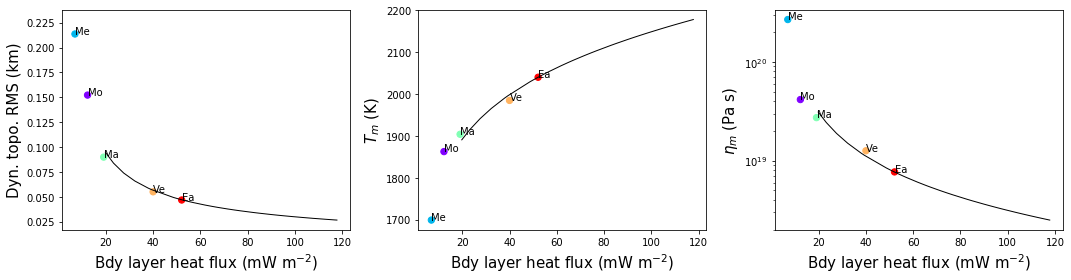

In [12]:
##### plot q_bl tradeoffs ######

# planets = build_solarsystem()
defaults = {'Ra_crit_u':450, 'c_m': 1142, 'k_lm':4, 'alpha_m':2.5e-5, 
            'h_rh':2.07e-3, 'a_rh':2.54, 
           }

save=False
ynames = {'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'T_m':('$T_m$ (K)',1),
         'eta_m':('$\eta_m$ (Pa s)',1),
        # 'D_l':('$D_l$ (km)', 1e-3),
        }
xname = {'q_ubl':('Bdy layer heat flux (mW m$^{-2}$)', 1e3)}
moreplanets = bulk_planets(N=50, name='M_p', mini=0.05*p.M_E, maxi=6*p.M_E, visc_type='KW', **defaults)
fig, axes = plot_vs_x(scplanets=planets, lplanets=moreplanets, xname=xname, ynames=ynames, 
                      labels=True, s=40, plots_save=True)

# add data 
q_data = [] # in mW/m2
h_data = [] # in km
labels = ['']

for ii in range(len(q_data)):
    axes[0].scatter(q_data[ii], h_data[ii], marker=markers[ii], c='k')
    axes[0].annotate(xy=(q_data[ii],h_data[ii]), s=labels[ii])
fig.savefig('q_scatter.png', bbox_inches='tight')

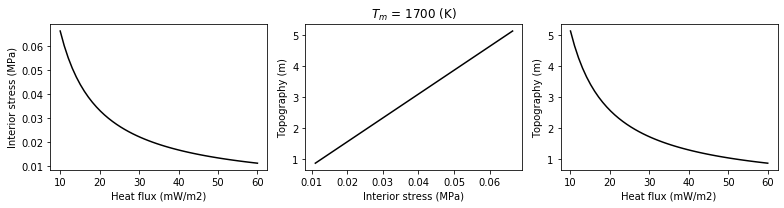

In [27]:
# plot lid stress
q_bl = np.linspace(10e-3, 60e-3)
T_m = 1700
def lid_stress(T_m=1600, eta_0=1e21, Ea=300e3, R_b=p.R_b, rho_m=3500, g_sfc=9.8, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, q_bl=20e-3):
    return 2.2*rho_m*alpha_m*g_sfc*(R_b*T_m**2/Ea)**2*k_m/q_bl

def int_stress(T_m=1600, eta_0=1e21, Ea=300e3, R_b=p.R_b, rho_m=3500, g_sfc=9.8, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, q_bl=20e-3):
    return 0.1*rho_m*alpha_m*g_sfc*(R_b*T_m**2/Ea)**2*k_m/q_bl

def stress_height(s=0.1e3, rho_m=3500, rho_w=0, g_sfc=9.8):
    delta_rho = rho_m - rho_w
    return s/(delta_rho*g_sfc)

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
s = int_stress(q_bl=q_bl, g_sfc=3.7, T_m=T_m)
h = stress_height(s=s, g_sfc=3.7)

axes[0].plot(q_bl*1e3, s*1e-6, 'k')
axes[0].set_xlabel('Heat flux (mW/m2)')
axes[0].set_ylabel('Interior stress (MPa)')

axes[1].plot(s*1e-6, h, 'k')
axes[1].set_xlabel('Interior stress (MPa)')
axes[1].set_ylabel('Topography (m)')

axes[2].plot(q_bl*1e3, h, 'k')
axes[2].set_xlabel('Heat flux (mW/m2)')
axes[2].set_ylabel('Topography (m)')

axes[1].set_title('$T_m$ = '+str(T_m)+' (K)')
plt.tight_layout()
fig.savefig('flux-stress-height.png', bbox_inches='tight')

/home/claire/Works/exo-top/thermal.py:84: RuntimeWarning: invalid value encountered in double_scalars
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
/home/claire/Works/exo-top/thermal.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
/home/claire/Works/exo-top/thermal.py:84: RuntimeWarning: divide by zero encountered in true_divide
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta


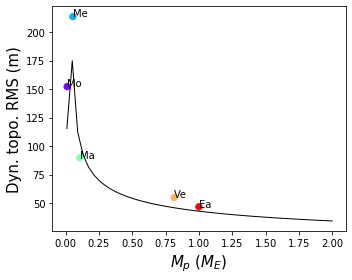

In [31]:
##### plot final evolution on single mass axis ######
planets = build_solarsystem(run_args={'visc_type':'KW'})

# TODO: add datapoints from literature on SS


ynames = {'dyn_top_rms':('Dyn. topo. RMS (m)', 1) 
#           ,'eta_m':('$\eta_m$', 1),
#          'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),'D_l':('$D_l$ (km)', 1e-3)
         }
xname = {'M_p':('$M_p$ ($M_E$)', p.M_E**-1)}
# xname = {'R_p':('$M_p$ (km)', 1e-3)}
defaults = {'Ra_crit_u':450, 'c_m':1142, 'k_lm':4, 'a_rh':2.44, 'alpha_m':2.5e-5, 'beta_u':1/3}
moreplanets = bulk_planets(N=50, name='M_p', mini=0.01*p.M_E, maxi=2*p.M_E, random=False, 
                          visc_type='KW', T_m0 = 1750,
                           **defaults)
fig, axes = plot_vs_x(scplanets=planets, 
                      lplanets=moreplanets, 
                      xname=xname, ynames=ynames, 
                      labels=True, s=40, plots_save=False)


# # compare analytical
# x=[]
# y=[]
# for pl in moreplanets:
#     anal = tp.TerrestrialPlanet(M_p=pl.M_p, **defaults)
#     anal.init_derived(**defaults)
#     anal.eta_m = rh.eta_KW(pl.T_m, pl=anal)
#     anal.q_ubl = q_bl_analytic(T_m=pl.T_m, pl=anal)
#     anal.q_sfc = anal.q_ubl # true in steady state
#     anal.RMS = top.dyn_topo(pl=anal, C=5.4)
#     x.append(anal.M_p)
#     y.append(anal.RMS[-1])
# fig.gca().plot(np.array(x)/p.M_E, y, c='k', lw=1, ls='--')



# data
 # Solomatov 
    
fig.savefig(fig_path+'RMS_v_mass.png', bbox_inshces='tight')

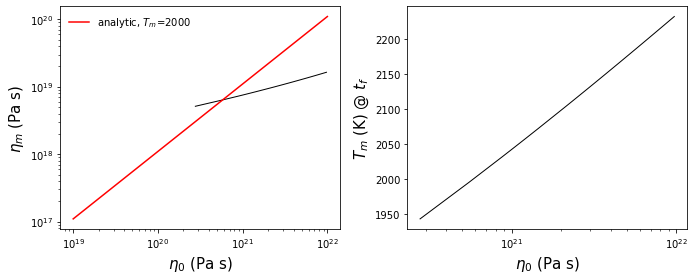

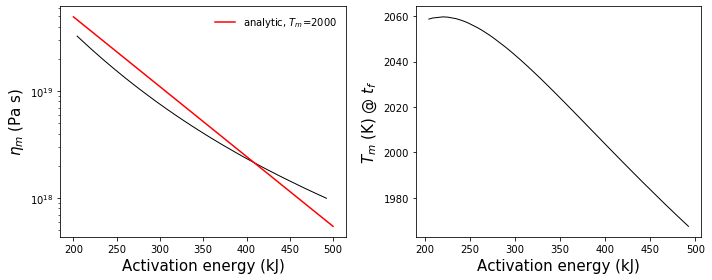

In [30]:
##### plot visc tradeoffs ######

# planets = build_solarsystem()
defaults = {'Ra_crit_u':450, 'c_m': 1142, 'k_lm':4, 'a_rh':2.54, 'alpha_m':2.5e-5, 'T_ref':1600}
ynames = {'eta_m':('$\eta_m$ (Pa s)', 1), 'T_m':('$T_m$ (K) @ $t_f$', 1)}
save=False

xname = {'eta_0':('$\eta_0$ (Pa s)',1)}
planets_eta0 = bulk_planets(N=50, name='eta_0', mini=1e18, maxi=1e22, **defaults)
fig0, axes0 = plot_vs_x(lplanets=planets_eta0, xname=xname, ynames=ynames, 
                      s=40, plots_save=save)

xname = {'Ea':('Activation energy (kJ)', 1e-3)}
planets_Ea = bulk_planets(N=50, name='Ea', mini=200e3, maxi=500e3, **defaults)
fig1, axes1 = plot_vs_x(lplanets=planets_Ea, xname=xname, ynames=ynames, 
                      s=40, plots_save=save)

# compare to analytical
T_m = 2000
Ea = 300e3
eta_0 = np.logspace(19, 22, num=100)
eta_m = eta_0*np.exp(Ea/p.R_b * (T_m**-1 - defaults['T_ref']**-1))
axes0[0].plot(eta_0, eta_m, c='r', label='analytic, $T_m$='+str(T_m))
axes0[0].legend(frameon=False)
fig0.savefig('eta0_test.png', bbox_inches='tight')

eta_0 = 1e21
Ea = np.linspace(200, 500, num=100) # in kJ
eta_m = eta_0*np.exp(Ea*1e3/p.R_b*(1/T_m - 1/defaults['T_ref']))
axes1[0].plot(Ea, eta_m, c='r', label='analytic, $T_m$='+str(T_m))
axes1[0].legend(frameon=False)
fig0.savefig('Ea_test.png', bbox_inches='tight')

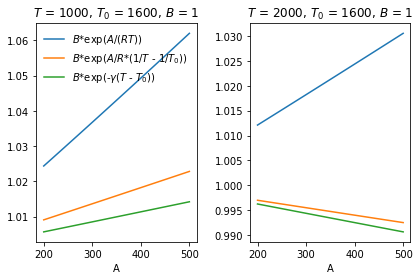

In [7]:
# regular arrhenius law
fig, axes = plt.subplots(1, 2)
B = 1
T = [1000, 2000]
T0 = 1600
A = np.linspace(200, 500, num=100) # in kJ
gamma = A/(p.R_b*T0**2)

for i, TT in enumerate(T):
    axes[i].plot(A, B*np.exp(A/(p.R_b*TT)), label='$B$*exp($A$/($RT$))')
    axes[i].plot(A, B*np.exp(A/p.R_b*(1/TT - 1/T0)), label='$B$*exp($A$/$R$*(1/$T$ - 1/$T_0$))') # difference
    axes[i].plot(A, B*np.exp(-gamma*(TT - T0)), label='$B$*exp(-$\gamma$($T$ - $T_0$))') # Frank-Kamenetskii
    axes[i].set_title('$T$ = '+str(TT)+', $T_0$ = 1600, $B$ = 1')
    axes[i].set_xlabel('A')
axes[0].legend(frameon=False)
plt.tight_layout()
plt.savefig('activation_energy.png', bbox_inches='tight')

Ea (22786.345773422203-402898.9062996133j)
eta0 2.1137706053129774e+23


/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False

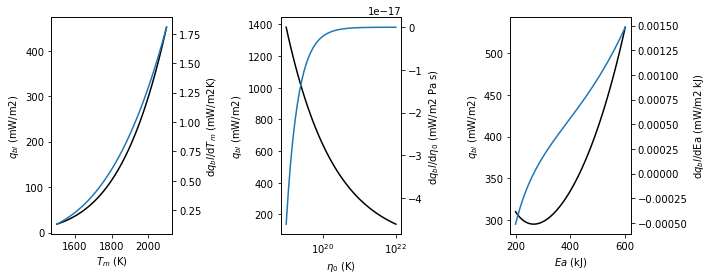

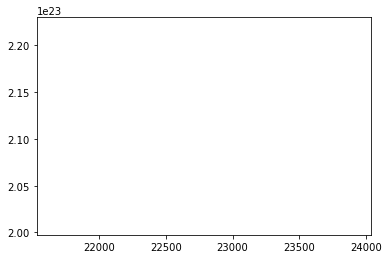

In [57]:
# analytic - derivatives

def dq_dT(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return eta_0*k_m*kappa_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333*(0.333333333333333*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(eta_0*kappa_m) + 0.666666666666667*R_b*T_m*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))*np.exp(Ea*(1/T_m - 1/T_0)/R_b)/(alpha_m*g_sfc*rho_m) + 2*R_b*T_m*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea

def dq_deta0(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return -0.333333333333333*R_b*T_m**2*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/(Ea*eta_0)

def dq_dEa(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return eta_0*k_m*kappa_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333*(-0.333333333333333*T_m**2*a_rh*alpha_m*g_sfc*rho_m*(1/T_m - 1/T_0)*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m) - 0.333333333333333*R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea**2*eta_0*kappa_m))*np.exp(Ea*(1/T_m - 1/T_0)/R_b)/(alpha_m*g_sfc*rho_m) - R_b*T_m**2*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea**2

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
T_m = np.linspace(1500, 2100)
ax1=axes[0]
ax1.plot(T_m, q_bl_analytic(T_m=T_m)*1e3, 'k')
ax1.set_xlabel('$T_m$ (K)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(T_m, dq_dT(T_m=T_m)*1e3)
ax2.set_ylabel('d$q_bl$/d$T_m$ (mW/m2K)')

ax1=axes[1]
eta_0 = np.logspace(19, 22)
ax1.plot(eta_0, q_bl_analytic(eta_0=eta_0)*1e3, 'k')
ax1.set_xlabel('$\eta_0$ (K)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(eta_0, dq_deta0(eta_0=eta_0)*1e3)
ax2.set_ylabel('d$q_bl$/d$\eta_0$ (mW/m2 Pa s)')
ax1.set_xscale('log')
ax2.set_xscale('log')
plt.tight_layout()

ax1=axes[2]
Ea = np.linspace(200e3, 600e3)
ax1.plot(Ea*1e-3, q_bl_analytic(Ea=Ea)*1e3, 'k')
ax1.set_xlabel('$Ea$ (kJ)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(Ea*1e-3, dq_dEa(Ea=Ea)*1e3)
ax2.set_ylabel('d$q_bl$/dEa (mW/m2 kJ)')
plt.tight_layout()

# function of eta
def eta_0(T_m=2000, q_bl=100e-3, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, eta_m=None):
    return R_b**4*T_m**8*a_rh**4*alpha_m*g_sfc*k_m**3*rho_m/(Ea**4*kappa_m*q_bl**3)
def Ea(T_m=2000, q_bl=100e-3, eta_0=1e21, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, eta_m=None):
    return R_b**4*T_m**8*a_rh**4*alpha_m*g_sfc*k_m**3*rho_m/(Ea**4*kappa_m*q_bl**3)

eta_m = np.linspace(50e-3, 200e-3, num=10)
fig, ax = plt.subplots(1,1)
for i, q in enumerate(q_bl):
    ax.plot(Ea_test, eta0_test, c=cm.jet(norm(q)) )

# hold q_bl constant



In [4]:
######  test effect of changing reference viscosity on Earth
names = {'T_m':('$T_m$ (K)',1), 
         'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'q_ubl':('$q_{bl}$ (mW m$^{-2}$)',1e3), 
         'eta_m':('$\log_{10} \eta_m$ (Pa s)',1), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1)
        }
save = False


h = rh.grain_size(A_rh=8.7e15, eta_0=1e21, Ea=300e3, T_ref=1600, m=2.5, B_rh=0.5e-9, mu=80e9)
print('h =',h*1e3, 'mm')

defaults = dict(
     Alb=None, 
     H_0=4e-12, # final radiogenic heating in W/kg
     X_K=305, # initial abundance of K in wt ppm
     X_U=16e-3, # initial abundane of U in wt ppm 
     X_Th=56e-3, # initial abundance of Th in wt ppm 
     L=None, 
     Ra_crit_u=450, 
     R_p0=3400e3, 
     R_c0=1700e3,
     alpha_m=2.5e-5, # thermal expansivity
     k_m=4, # silicate thermal conductivity
     CMF=0.24, # not used
     rho_c=7200, # core density
     rho_m=3500, # mantle density 
     rho_lith=None, 
     c_m=1142, #<----??? TODO: check if you need constant volume c_p
     c_c=840, # specific heat for core in J/K/kg
     k_lm=4, # thermal conduvtivity lower mantle
     beta_u=None, # defaults to 1/3
     beta_c=None, # defaults to 1/3 
     a_rh=2.44, # for beta=1/3 
     Ea=300e3, # activation energy in J for viscosity law
     T_s=250, # fixed surface temp in K
     M_p=6.39e23, # only used for gravity in this case
     sma=None, 
     g_sfc = 3.7,
    mu=80e9, A_rh=8.7e15, 
#     h_rh=2.07e-3,
    B_rh=0.5e-9, m_rh=2.5
     )
kwargs = dict(T_m0=1750, T_c0=2250, D_l0=300e3, t0=0, tf=4.5, visc_type='KW', complexity=3) # model params
h_vec = np.linspace(1e-3, 10e-3, num=30)
cols = colorize(Ea_vec, cmap='rainbow')[0]
for ii, h_rh in enumerate(h_vec):
    pl = tp.TerrestrialPlanet(h_rh=h_rh, **defaults)
    pl = therm.solve(pl, **kwargs) # T_m, T_c, D_l
    pl.dyn_top_rms = top.dyn_topo(pl=pl, C=5.4, **kwargs)
    if ii==0:
        fig=None
        axes=None
    fig, axes = plot_output(pl, names, ncols=2, plots_save=save, fig=fig, axes=axes, col=cols[ii],
#                             label='%d kJ'%(Ea*1e-3), 
                            verbose=False, fig_path=fig_path, legend=False, labelsize=14,
                            title='Mars: Varying grain size', **kwargs)


sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=h.min()*1e3, vmax=h.max()*1e3))
sm._A = []
fig.subplots_adjust(right=0.85, wspace=0.5)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('Grain size (mm)', fontsize=14)

if save:
    fig.savefig(fig_path+'h-effect-evol.png', bbox_inches='tight')

h = 2.0721961953453367 mm


NameError: name 'Ea_vec' is not defined

In [39]:
dict_eval = dict(
    g_sfc=3.7,H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             Ra_crit_u=450, 
                             R_p=3400e3, 
                             R_c=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                              mu=80e9, A_rh=8.7e15, R_b = 8.314, Ra_crit = 450, kappa_m = 9.6e-7,
                     h_rh=2.07e-3, B_rh=0.5e-9, m_rh=2.5)
pl = tp.TerrestrialPlanet(**dict_eval)
pl = therm.solve(pl,T_m0=1750, T_c0=2250, D_l0=300e3, t0=0, tf=4.5, visc_type='KW') # T_m, T_c, D_l
print('(alpha_m*rho_m*g_sfc*(T_c-T_m) / (kappa_m*eta_m))', (pl.alpha_m*pl.rho_m*pl.g_sfc*(pl.T_c[0]-pl.T_m[0]) / (pl.kappa_m*pl.eta_m[0])))
print('(alpha_m*rho_m*g_sfc*(T_c-T_m))', (pl.alpha_m*pl.rho_m*pl.g_sfc*(pl.T_c[0]-pl.T_m[0]) ))
print(pl.g_sfc)
print('pl.T_c[0]-pl.T_m[0]', pl.T_c[0]-pl.T_m[0])
print(pl.alpha_m)
print('T_l', pl.T_l[0])
print('delt_u', pl.TBL_u[0])
print(pl.T_m[0] - pl.T_l[0])
print(pl.q_ubl[0])
print('kappa_m*eta_m', pl.kappa_m*pl.eta_m[0])
print('kappa_m', pl.kappa_m)
print('eta_m', pl.eta_m[0])


(alpha_m*rho_m*g_sfc*(T_c-T_m) / (kappa_m*eta_m)) 1.0245750917545387e-12
(alpha_m*rho_m*g_sfc*(T_c-T_m)) 147.99571494312585
3.382759198700019
pl.T_c[0]-pl.T_m[0] 500.0
2.5e-05
T_l 1542.900663815
delt_u 67720.38705557966
207.09933618500008
0.012232613851721134
kappa_m*eta_m 144445942648956.9
kappa_m 1.0007505629221917e-06
eta_m 1.4433760819197016e+20


In [4]:
def q_bl_analytic(T_m=2000, pl=None, eta_0=1e21, Ea=300e3,  a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=1e-6, P=0, V_rh=6e-6, mu=80e9, A_rh=8.7e15, T_c=None,
                  h_rh=10**-2, B_rh=0.5e-9, m_rh=2.5, visc_type='KW', Ra_crit=450, **kwargs):
#     print('\nanalytic')
    if pl is not None:
        Ea = pl.Ea
        V_rh = pl.V_rh
        mu = pl.mu
        A_rh = pl.A_rh
        B_rh = pl.B_rh
        m_rh = pl.m_rh
        h_rh = pl.h_rh
        a_rh = pl.a_rh
        g_sfc = pl.g_sfc
        rho_m = pl.rho_m
        k_m = pl.k_m
        alpha_m = pl.alpha_m
        kappa_m = pl.kappa_m
        eta_0 = pl.eta_0
        T_0 = pl.T_ref
        V_rh = pl.V_rh
        Ra_crit = pl.Ra_crit_u    
    if visc_type is 'Thi':
        return p.R_b*T_m**2*a_rh*k_m*(p.R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/p.R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea
    elif visc_type is 'KW':
        h=1
        T_l = T_m - a_rh*(p.R_b*T_m**2/Ea)
        dT_conv = T_m - T_l
        dT_flux = T_m - T_l
        if T_c is not None:
            dT_conv = T_c - T_l
        eta_m = mu/(2*A_rh) * (h_rh/B_rh)**m_rh * np.exp(Ea/(p.R_b*T_m))
        Ra_rh = alpha_m*rho_m*g_sfc*dT_conv*h**3/(kappa_m*eta_m)
        delta_bl = h*(Ra_crit/Ra_rh)**(1/3)
        q_bl = k_m*dT_flux/delta_bl
#         print('T_m', T_m, 'Ea', Ea, 'a_rh', a_rh, 'rho_m', rho_m, 'g_sfc', g_sfc, 'k_m', k_m, 'alpha_m', alpha_m, 'kappa_m', kappa_m, 'mu', mu, 'A_rh', A_rh, 'Ra_crit', Ra_crit,  'h_rh', h_rh, 'B_rh', B_rh, 'm_rh', m_rh)
#         print('dT_conv', dT_conv, 'dT_flux', dT_flux)
#         print('eta_m', eta_m)
#         print('delta_bl', delta_bl)
#         print('Ra_rh', Ra_rh)
        return q_bl
#         return k_m*alpha_m**(1/3)*rho_m**(1/3)*g_sfc**(1/3)*(2*A_rh)**(1/3)*a_rh**(4/3)*p.R_b**(4/3)*T_m**(8/3) / (Ra_crit**(1/3)*kappa_m**(1/3)*mu**(1/3)*(h_rh/B_rh)**(m_rh/3)*Ea**(4/3)*np.exp(Ea/(3*p.R_b*T_m)))

def plot_q_tradeoff(yfunc, vec_z, param_z, zscale=1, yscale=1, zlabel=None, cmap='rainbow',
                    ylabel=None, labelsize=16, yargs=None, xlim=None, ylim=None, cbar_log=False, log=False,
                    fig=None, ax=None, title='', xlabel=None, T_min=1000, T_max=2000, defaults=None):
    T_m = np.linspace(T_min, T_max, num=50)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if zlabel is None:
        zlabel=param_z
    c = colorize(vec_z, cmap=cmap)[0]
    yargs={}
    yargs.update(defaults)
    for ii, val in enumerate(vec_z): # line for each value in z-parameter
        yargs.update({param_z:val})
        q_bl = q_bl_analytic(T_m=T_m, **yargs)
        eta_m = rh.eta_KW(T_m, **yargs)
        y = yfunc(T_m=T_m, T=T_m, q_ubl=q_bl, F=q_bl, eta_m=eta_m, **yargs) # must be a function of q_bl
        ax.plot(q_bl*1e3, y*yscale, c=c[ii])
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if cbar_log:
        norm=colors.LogNorm()
    else:
        norm=None
    if log:
        ax.set_yscale('log')
    sc = plt.scatter(vec_z, vec_z, c=vec_z*zscale, cmap=cmap, norm=norm)
    sc.set_visible=False
    cax = plt.colorbar(sc, ax=ax)
    cax.ax.set_ylabel(zlabel, fontsize=labelsize, rotation=270, labelpad=20)
    ax.set_title(title, fontsize=labelsize)
    return fig, ax

def analytical_tradeoff_subplots(z=None, y=None, res=10, labelsize=12, T_min=1000, T_max=2000, suptitle='',
                                 xlim=[0, 60], zlims=None, ylims=None, defaults=None, cmap=None):
    nrows = len(z)
    ncols = len(y)
    if cmap is None:
        cmap = ['gist_heat']*nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    yfuncs = list(y.keys())
    ylabels = list(y.values()) # tuple (ylabel, yscale)
    zvars = list(z.keys()) # colorbar vector
    zlabels = list(z.values()) # tuple (zlabel, zscale)
    
    for icol in range(ncols):
        xlabel=''
        if 'eta' in yfuncs[icol]:
            log=True
        else:
            log=False
        for irow in range(nrows):
            if (irow==0) and (icol==0):
                title=suptitle
#                 print('max topo', top.max_topo(T_m=1500, q_ubl=q_bl_analytic(T_m=1500, **defaults), **defaults))
            elif (irow==0) and (icol==1):
                title = '%d'%T_min+' < $T_m$ < '+'%d'%T_max+' K'
            else:
                title = ''
            if irow == nrows-1:
                xlabel = '$q_{bl}$ (mW m$^{-2}$)'
            zmin, zmax = zlims[irow]
            fig, ax = plot_q_tradeoff(yfunc=eval(yfuncs[icol]), cmap=cmap[irow],
                                      vec_z=np.linspace(zmin, zmax, num=res), param_z=zvars[irow],
                                      zscale=zlabels[irow][1],yscale=ylabels[icol][1],
                                      zlabel=zlabels[irow][0], 
                                      ylabel=ylabels[icol][0],
                                      xlabel=xlabel,
                                      defaults=defaults,title=title,log=log,
                                      xlim=xlim, ylim=ylims[icol], labelsize=labelsize,
                                      fig=fig, ax=axes[irow][icol], 
                                     )
    
    plt.subplots_adjust(wspace=1)
    return fig


max qbl at T= [2063.28660985]
max qbl/qsfc at T= [2049.84995352]


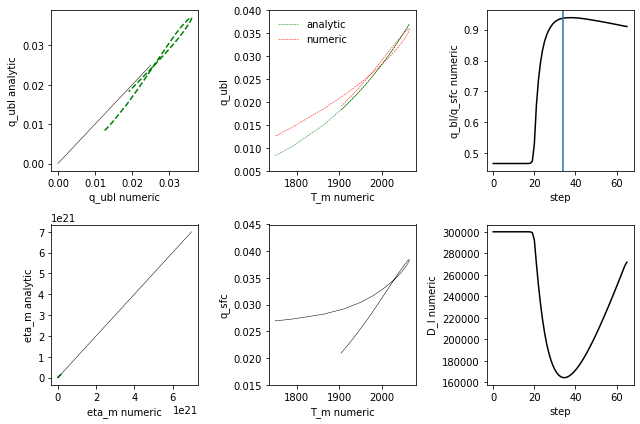

In [36]:
# compare analytic and numerical
plargs = dict(Alb=None, 
                             H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             L=None, 
                             Ra_crit_u=450, 
                             R_p0=3400e3, 
                             R_c0=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             rho_lith=None, 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             beta_u=None, # defaults to 1/3
                             beta_c=None, # defaults to 1/3 
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                             sma=None, 
                             ident='Mars1')
Mars1 = tp.TerrestrialPlanet(**plargs)
model_args = dict(T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, 
                  visc_type='KW',
              complexity=3) # model params
Mars1 = therm.solve(Mars1, **model_args) # T_m, T_c, D_l


Mars1_anal = tp.TerrestrialPlanet(**plargs)
Mars1_anal.init_derived( **plargs)
Mars1_anal.eta_m = rh.eta_KW(Mars1.T_m, pl=Mars1_anal)
Mars1_anal.q_ubl = q_bl_analytic(T_m=Mars1.T_m, pl=Mars1_anal, **plargs)


T_m = Mars1.T_m
q_ubl = Mars1.q_ubl
ratio = q_ubl/Mars1.q_sfc
i_max = np.where(q_ubl==np.max(q_ubl))[0][0]


fig, axes = plt.subplots(2, 3, figsize=(9,6))
ax = axes[0][0]
ax.plot(Mars1.q_ubl, Mars1_anal.q_ubl, 'g--') # not the same clearly
ax.plot(np.linspace(0, 0.025), np.linspace(0, 0.025), 'k', lw=0.5)
ax.set_xlabel('q_ubl numeric')
ax.set_ylabel('q_ubl analytic')

ax = axes[1][0]
ax.plot(Mars1.eta_m, Mars1_anal.eta_m, 'g--')
ax.set_xlabel('eta_m numeric')
ax.set_ylabel('eta_m analytic')
ax.plot(np.linspace(0, 7e21), np.linspace(0, 7e21), 'k', lw=0.5)

ax = axes[0][1]
ax.plot(Mars1.T_m, Mars1_anal.q_ubl, 'g--', lw=0.5, label='analytic') # backtrack because temp not monotonically increase
ax.plot(Mars1.T_m, Mars1.q_ubl, 'r--', lw=0.5, label='numeric')
ax.set_xlabel('T_m numeric')
ax.set_ylabel('q_ubl')
ax.legend(frameon=False)
ax.set_ylim(0.005, 0.04)

ax = axes[1][1]
ax.plot(Mars1.T_m, Mars1.q_sfc, 'k', lw=0.5, label='numeric')
ax.set_xlabel('T_m numeric')
ax.set_ylabel('q_sfc')
ax.set_ylim(0.015, 0.045)


ax = axes[0][2]
ax.plot(Mars1.q_ubl/Mars1.q_sfc, 'k')
ax.axvline(i_max)
ax.set_xlabel('step')
ax.set_ylabel('q_bl/q_sfc numeric')

ax = axes[1][2]
ax.plot(Mars1.D_l, 'k')
ax.set_xlabel('step')
ax.set_ylabel('D_l numeric')

plt.tight_layout()


print('max qbl at T=',T_m[np.where(q_ubl==np.max(q_ubl))])
print('max qbl/qsfc at T=',T_m[np.where(ratio==np.max(ratio))])

